# Модель предсказания ухода клиентов для оператора связи "ТелеДом"

**Описание проекта:**

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 
_______________


**Цель**
- Построить модель машинного обучения, которая по входным признакам будет предсказывать, разорвет ли клиент контракт с операторов связи.

**Задача**
- Построить несколько моделей МО, включая градиентный бустинг
- Выбрать наиболее эффективную модель
- Достичь значения ROC-AUC более 85 на тестовой выборке
- Проанализировать результаты и сделать выводы для бизнеса

**План работы**
1. Загрузка данных
2. Предобработка и исследовательский анализ данных
3. Объединение датасетов
4. Создание и отбор признаков
5. Исследовательский анализ данных объединенного датасета
6. Корреляционный анализ данных
7. Подготовка данных для обучения модели
8. Обучение моделей МО
9. Выбор лучшей модели
10. Проверка на тестовой выборке и рекомендации заказчику
11. Общий вывод

_________ 
**Описание данных:**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

4 датасета.
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

*1 contract_new.csv*:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

*2 personal_new.csv*:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

*3 internet_new.csv*
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

*4 phone_new.csv*
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.


_____

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь (*можно подключить к нескольким линиям одновременно*) и интернет (*типы подключения: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic)*).

Также доступны:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Оплата за услуги: 
- каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

___________
___________
___________

**Перед началом работы:**

In [1]:
pip install phik shap -U scikit-learn shap optuna catboost lightgbm optuna-integration[sklearn] -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Импорт библиотек**

In [2]:
import pandas as pd
import numpy as np
import re
import phik

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
## Бустинги
import catboost, lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Модули для работы с моделями, переборы гиперпараметров:
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Кодировщики, масштабировние
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Метрики
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score

**Константы**

In [3]:
RANDOM_STATE = 100225
TEST_SIZE = 0.25 

Информация о договорах актуальна на 1 февраля 2020 года:

In [4]:
# Дата выгрузки
upload_date = '2020-02-01'

**Используемые функции:**

In [5]:
# Функция для изменения названий столбцов
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

# 1. Для поиска и просмотра явных дубликатов:
def duplicates_find(df):
    return df.duplicated().sum()

# 2. Для просмотра уникальных значений объектов типа Object: 
def uniques(df):
    for column in df.columns:
        print (f'{column}: \n {df[column].unique()}')
        print (f'Количество уникальных значений: {df[column].nunique()}\n')
            
# 3. Описательная статистика в удобном форматеЖ
def to_describe(df):
    return pd.DataFrame(df.describe()).T

# 4. Построение гистограмм и боксплотов
def graph(df, bins, x_name, y_name, h_title, stat_type, x, hue_n):
    f, ax = plt.subplots(2, 1)
    f.set_size_inches(12, 7)
    #plt.suptitle(f'{x_name}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=x, bins=bins, color='coral', edgecolor=None, stat=stat_type, hue=hue_n, ax=ax[0])
    ax[0].set_title(h_title)
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel(y_name)
    # Ящик с усами:
    sns.boxplot(data=df, x=x, hue=hue_n, orient='h', color='gray')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.subplots_adjust(wspace=1, hspace=0.5)
    plt.show()

    if x==None:
        display(pd.DataFrame(df.describe()).T)
    else:
        display('не завершенные:', pd.DataFrame(df.query('ended==0')[x].describe()).T)
        display('завершенные:', pd.DataFrame(df.query('ended==1')[x].describe()).T)

# 5. Круговые диаграммы с разбиением на таргет
def compare_pie(df, df2, y):
    plt.figure(figsize=(13,5))
    p=1
    for i in [df, df2]:
        plt.subplot(1, 2, p)
        plt.suptitle(f'{y}', fontweight='bold')
        plt.pie(x=i.groupby(y)[y].count(), labels=i.groupby(y)[y].count().index, 
                autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(titles_for_pie[p-1])
        p +=1
    plt.show()

_______
_______
_______

<a id="1"></a> 
## Загрузка данных

Загрузим данные и ознакомимся с ними:

In [6]:
contract = pd.read_csv("C:\Я.Практикум\проекты\8_финальный\contract_new.csv")
personal = pd.read_csv("C:\Я.Практикум\проекты\8_финальный\personal_new.csv")
internet = pd.read_csv("C:\Я.Практикум\проекты\8_финальный\internet_new.csv")
phone = pd.read_csv("C:\Я.Практикум\проекты\8_финальный\phone_new.csv")

for i in [contract, personal, internet, phone]:
    display (i.head())
    print (i.info(), '\n____________________________________\n')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 
____________________________________



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None 
____________________________________



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None 
____________________________________



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None 
____________________________________



### Вывод

**Общее описание данных:**

В каждом из датасетов присутствует признак `customerID`. В дальнейшем будем использовать в качестве ключа, чтобы объединить необходимые признаки из разных таблиц в один датасет. 

Все датасеты содержат разную информацию, имеют разную структуру, размерность и типы данных. Ознакомимся более детально:

**1. contract:**

- 7043 строк
- 8 столбцов

В основном видим даты и категориальные признаки.

1 признак типа float - `MonthlyCharges`, остальные object.

***На этапе предобработки:***
- *следует заменить тип `BeginDate` и `EndDate` на datetime,*
- *привести названия столбцов к нижнему регистру, для удобства работы.*

**2. personal:**

- 7043 строк
- 5 столбцов

1 признак типа int - `SeniorCitizen`, остальные object.

**3. internet:**

- 5517 строк (Замечаем отличие от первых двух датасетов)
- 8 столбцов

Все признаки имеют тип object - категориальные переменные.

**4. phone:**

- 6361 строк (также замечаем отличие от первых двух датасетов)
- 2 столбца

Все признаки имеют тип object - категориальные переменные.

__________
**Выбор целевой переменной:**

Следует создать на основе признака `EndDate`.  
Значения:
- `1` ,  если для клиента есть дата окончания действия договора (клиент ушел)
- `0` ,  если в дате окончания действия договора стоит 'No' (клиент не ушел, продолжает пользоваться услугой)
__________
**Вывод к предобработке данных:**

Следует:
- *заменить тип `total_charges` - на float, `BeginDate` и `EndDate` - на datetime (можно позже, после создания целевой переменной и нового признака)*
- *привести названия столбцов к нижнему регистру, для удобства работы.*

<a id="2"></a> 
## Предобработка и исследовательский анализ данных

### Приведение названий столбцов к нижнему регистру

In [7]:
names = []
for p in [contract, personal, internet, phone]:
    names = []
    for i in p.columns:
        names.append(camel_to_snake(i))
    p.columns = names
    display (p.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Index(['customer_id', 'multiple_lines'], dtype='object')

- Названия столбцов приведены к виду under_score 

Далее поработаем с каждым датасетом отдельно.

### Проверка на дубликаты и пропуски

**Дубликаты и пропуски:**

In [8]:
datasets = ['contract', 'personal', 'internet', 'phone']
p=0
duplicates_sum = []
for i in [contract, personal, internet, phone]:
    duplicates_sum.append(duplicates_find(i))
    p+=1
print('Дубликатов всего:', sum(duplicates_sum))

p=0
null_sum = []
for i in [contract, personal, internet, phone]:
    null_sum.append((contract.isna().sum()).sum())
    p+=1
print ('\nВсего пропусков: ', sum(null_sum))

Дубликатов всего: 0

Всего пропусков:  0


**Проверим, что айди клиентов не повторяются и уникальны:**

In [9]:
p=0
print ('Разница между длиной датасета и количеством уникальных айди в нем: \n')
for i in [contract, personal, internet, phone]:
    print(f'{datasets[p]}: ', len(i) - i['customer_id'].nunique())
    p+=1

Разница между длиной датасета и количеством уникальных айди в нем: 

contract:  0
personal:  0
internet:  0
phone:  0


- Для каждого датасета выполняется условия равенства длины датасета и количества уникальных айди. Айди уникальны/

**Итого:**
- Явных дубликатов и пропусков в датасетах не обнаружено.
- Айди уникальны.

Далее ознакомимся с каждым датасетом более подробно:

### contract

**Уникальные значения:**

*Исключим признаки `begin_date`, `total_charges`, т.к. в них много значений*

In [10]:
uniques(contract.drop(['begin_date'], axis=1))

customer_id: 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений: 7043

end_date: 
 ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' 

- Нет повторяющихся по смыслу значений. Вносить изменения не требуется.

*Какие данные имеем:*

`type`:
- три вида оплаты: помесячная, за год, за два года

`paperless_billing`:
- два значения: да/нет (безналичный расчет)

`payment_method`:
- 4 вида типа платежа: электронный чек, чек по почте, автоматическая оплата картой, автом. оплата кредитной картой

`end_date`:
- Приведены даты и одно текстовое значение - 'No' - , означающее, что даты окончания действия договора нет.

**`begin_date` - Количество заключенных и расторгнутых договоров по годам:**

*Здесь исключаем из end_date значение "No", чтобы привести столбец к нужному типу для получения года*

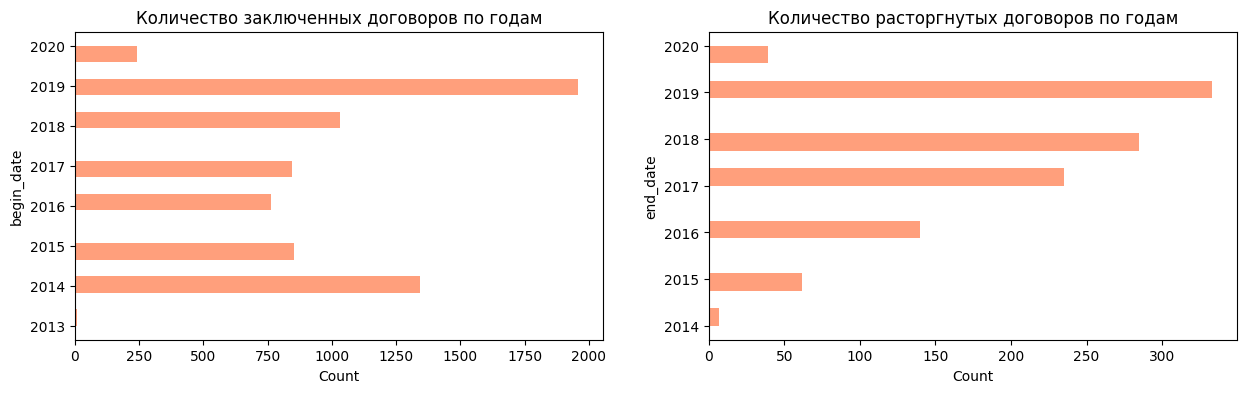

Заключенные договоры:


,count,mean,std,min,25%,50%,75%,max
begin_date,7043.0,2016.878603,1.970573,2013.0,2015.0,2017.0,2019.0,2020.0



Расторгнутые договоры:


,count,mean,std,min,25%,50%,75%,max
end_date,1101.0,2017.711172,1.301102,2014.0,2017.0,2018.0,2019.0,2020.0


In [11]:
plt.figure(figsize=[15, 4])
plt.subplot(1, 2, 1)
sns.histplot(y=pd.DatetimeIndex(pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')).year, color='coral', edgecolor=None)
plt.title('Количество заключенных договоров по годам')

plt.subplot(1, 2, 2)
sns.histplot(y=pd.DatetimeIndex(pd.to_datetime(contract.query('end_date!="No"')['end_date'], format='%Y-%m-%d')).year, color='coral', edgecolor=None)
plt.title('Количество расторгнутых договоров по годам')
plt.show()

print ('Заключенные договоры:')
display(to_describe(pd.DataFrame(pd.DatetimeIndex(pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')).year)))

print ('\nРасторгнутые договоры:')
to_describe(pd.DataFrame(pd.DatetimeIndex(pd.to_datetime(contract.query('end_date!="No"')['end_date'], format='%Y-%m-%d')).year))

- Наибольшее кол-во заключенных договоров - в 2014 и 2019 года
- Наибольшее кол-во расторгнутых договоров - в 2017-2019 годах

*В дальнейшем на основе этих признаков создадим новый входной признак (длительность договора) и целевую переменную.*

**Расходы за месяц**

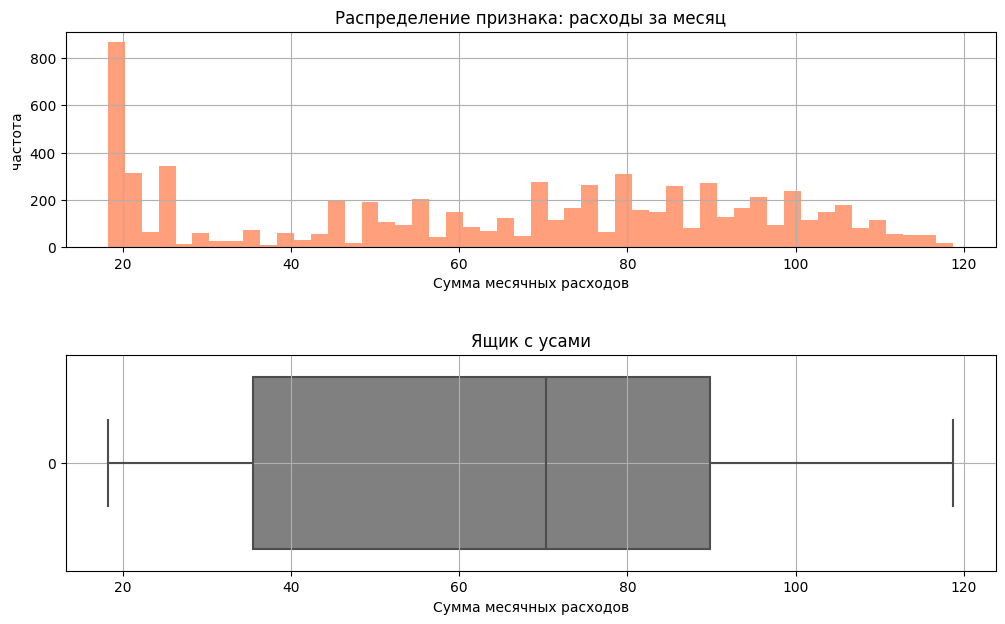

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [12]:
graph(contract['monthly_charges'], 50, 'Сумма месячных расходов', 'частота', 'Распределение признака: расходы за месяц', 'count', None, None)

- Имеем траты от 18,25 до 118,75 у.е. в месяц
- Медиана 70.35
- Среднее 64.76

**total_charges - общие расходы:**

Ранее видели, что у признака тип object. Посмотрим, нет ли нечисловых значений:

In [13]:
contract['total_charges'].sort_values()

3331          
4380          
6670          
488           
3826          
         ...  
2880    997.78
3267    998.89
6023     999.6
1700     999.6
1625     999.9
Name: total_charges, Length: 7043, dtype: object

- Есть значения с пустой строкой.

Уберем значения, состоящие из одного пробела:

In [14]:
contract.loc[contract['total_charges']!=' ', 'total_charges'].sort_values().head()

1272    100.17
3724    100.19
3185     100.2
1173    100.24
6564    100.25
Name: total_charges, dtype: object

- Из нечисловых значений имеем только пустую строку

In [15]:
contract.loc[contract['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


У всех таких клиентов дата подключения совпадает с датой выгрузки данных. Соответственно, в этот день они внесли свой первый платеж за месяц - он и равен общему расходу абонента на момент выгрузки.

**Произведем замену ' ' на значения месячного платежа:**

In [16]:
contract.loc[contract['total_charges']==' ', 'total_charges'] = contract['monthly_charges']

# Проверяем, что таких строк больше не осталось:
display(contract.loc[contract['total_charges']==' ', 'total_charges'])

# Приводим к типу float:
contract['total_charges'] = contract['total_charges'].astype('float')
contract['total_charges'].dtype

Series([], Name: total_charges, dtype: object)

dtype('float64')

**График распределения значений:**

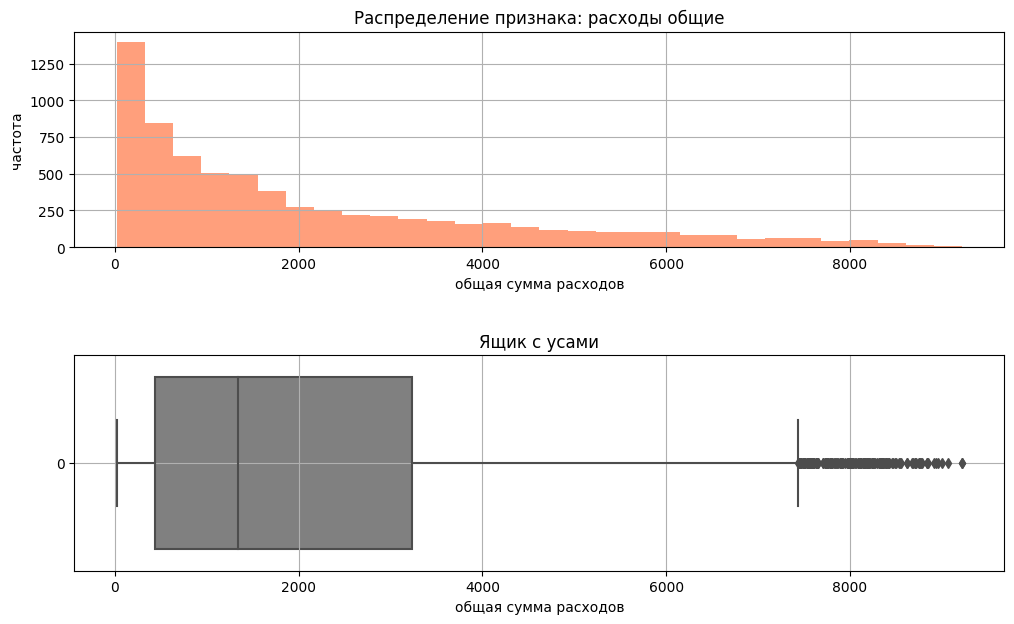

,count,mean,std,min,25%,50%,75%,max
total_charges,7043.0,2115.377573,2112.678861,19.05,436.75,1343.35,3236.69,9221.38


In [17]:
graph(contract['total_charges'], 30, 'общая сумма расходов', 'частота', 'Распределение признака: расходы общие', 'count', None, None)

- Значения от 19.05 до 9221.38
- Среднее 2115
- В 50% случаев - от 436 до 3237

**Итого:**

Имеем категориальные признаки
- `type` - три вида оплаты: помесячная, за год, за два года,
- `paperless_billing` - получают ли эл-ный платежный лист: да/нет,
- `payment_method` - 4 вида типа платежа

Даты:
- `begin_date` - заключенные договоры с 2013 по 2020 годы,
- `end_date` - расторгнутые договоры с 2014 по 2020 год + значение 'No' (даты окончания действия договора нет)

Расходы:
- `monthly_charges` - за месяц -  от 18,25 до 118,75 у.е. в месяц
- `total_charges` - общие абонента - от 19.05 до 9221.38



*Предобработка:*
- *В `total_charges` заменили пустые значения на значение месячного платежа, привели столбец к типу float.*

**В дальнейшем:**
- Используем даты начала и окончания договоров для создания целевого признака и нового входного - длительности договора.

### personal

**Уникальные значения:**

In [18]:
uniques(personal)

customer_id: 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений: 7043

gender: 
 ['Female' 'Male']
Количество уникальных значений: 2

senior_citizen: 
 [0 1]
Количество уникальных значений: 2

partner: 
 ['Yes' 'No']
Количество уникальных значений: 2

dependents: 
 ['No' 'Yes']
Количество уникальных значений: 2



- Нет повторяющихся по смыслу значений.

**Итого:**

Датасет содержит информацию о клиентах:
- Пол - 2 значения (муж, жен)
- Супруг/супруга - 2 значения (да, нет)
- Пенсионер - 0/1 (да, нет)

### internet

In [19]:
uniques(internet)

customer_id: 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений: 5517

internet_service: 
 ['DSL' 'Fiber optic']
Количество уникальных значений: 2

online_security: 
 ['No' 'Yes']
Количество уникальных значений: 2

online_backup: 
 ['Yes' 'No']
Количество уникальных значений: 2

device_protection: 
 ['No' 'Yes']
Количество уникальных значений: 2

tech_support: 
 ['No' 'Yes']
Количество уникальных значений: 2

streaming_tv: 
 ['No' 'Yes']
Количество уникальных значений: 2

streaming_movies: 
 ['No' 'Yes']
Количество уникальных значений: 2



- Нет повторяющихся по смыслу значений.

**Итого:**

Все признаки категориальные.
- Тип подключения - 'DSL' или 'Fiber optic'

Признаки, содержащие только значения Да/Нет:
- Блокировка опасных сайтов, облачное хранилище, тех поддержка, антивирус, стриминговое ТВ, каталог фильмов

### phone

In [20]:
uniques(phone)

customer_id: 
 ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений: 6361

multiple_lines: 
 ['No' 'Yes']
Количество уникальных значений: 2



- Нет повторяющихся по смыслу значений.

**Итого:**

Единственный признак отображает, есть ли у абонента функция подключения телефона к нескольким линиям одновременно:
- да/нет

### Вывод по 2 разделу

**Предобработка:**
- Названия столбцов всех датасетов приведены к виду under_score: Большие буквы заменены на маленькие, слова разделены нижним подчеркиванием.
- В `total_charges` датасета contracts заменили пустые значения на значение месячного платежа, привели столбец к типу float.

**В результате проверки:**
- Пропусков и дубликатов (явных) в датасете не выявлено.
- Айди каждого клиентов в каждом из датасетов представлен не более одного раза.


**Какую информацию содержат датасеты:**

`contract`:
- `type` - три вида оплаты: помесячная, за год, за два года,
- `paperless_billing` - получают ли эл-ный платежный лист: да/нет,
- `payment_method` - 4 вида типа платежа
- `begin_date` - заключенные договоры с 2013 по 2020 годы,
- `end_date` - расторгнутые договоры с 2014 по 2020 год + значение 'No' (даты окончания действия договора нет)
- `monthly_charges` - за месяц -  от 18,25 до 118,75 у.е. в месяц
- `total_charges` - общие абонента - от 19.05 до 9221.38


`personal`:
- Пол - 2 значения (муж, жен)
- Супруг/супруга - 2 значения (да, нет)
- Пенсионер - 0/1 (да, нет)

`internet`:
- Тип подключения - 'DSL' или 'Fiber optic'
- Признаки, содержащие только значения Да/Нет:
  - Блокировка опасных сайтов, облачное хранилище, тех поддержка, антивирус, стриминговое ТВ, каталог фильмов

`phone`:
- есть ли функция подключения телефона к нескольким линиям одновременно:
  - да/нет



**В дальнейшем:**
- Используем даты начала и окончания договоров для создания целевого признака и нового входного - длительности договора.

<a id="3"></a> 
## Объединение датасетов

Объединим все 4 датасета в один:

In [21]:
data = contract.copy()

data = data.join(personal.set_index('customer_id'), on='customer_id', how='outer')
data = data.join(internet.set_index('customer_id'), on='customer_id', how='left')
data = data.join(phone.set_index('customer_id'), on='customer_id', how='left').set_index('customer_id')

display(data.head(2))

# сравним количество столбцов нового датасета с суммарным количеством столбцов в 4 изначальных датасетах (минус 4 * айди), 
# чтобы убедиться, что таблицы объединены корректно
print ('Количество столбцов\n- изначально:', contract.shape[1] + personal.shape[1] + internet.shape[1] + phone.shape[1] - 4)
print ('- объединенный датафрейм:', data.shape[1])

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


Количество столбцов
- изначально: 19
- объединенный датафрейм: 19


- Успешно

**Проверка на пропуски:**

In [22]:
data.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

- *Для многих пользователей нет информации об интернет-услугах.*

Посмотрим на пропуски:

In [23]:
data.drop(contract.drop('customer_id', axis=1).columns, axis=1).loc[data.isnull().any(axis=1)]

,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
6713-OKOMC,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
7469-LKBCI,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8191-XWSZG,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...
2235-DWLJU,Female,1,No,No,DSL,No,No,No,No,Yes,Yes,NaN
0871-OPBXW,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7750-EYXWZ,Female,0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,NaN


**Вывод:**
- Пропуски в информации в internet обычно есть для всех столбцов, в т.ч. `internet_service`. Значит, пропущены значения для клиентов, не пользующихся интернетом - можно смело заменять пропуски на 'No'
- Пропуски в multiple_lines характерны для клиентов, пользующихся интернетом. Значит, также можем заменить пропуски на 'No' - эти клиенты просто не пользуются услугами телефонной связи.

**Решение:**
- Заменяем пропуски на 'No'

**Заполнение пропусков:**

In [24]:
data = data.fillna('No')
print ('Пропусков после обработки:', data.isna().sum().sum())

Пропусков после обработки: 0


### Вывод

Датасеты объединены.

В следствие объединения были обнаружены пропуски - все заполнены значением 'unknown', поскольку на основании других признаков нужные категории с уверенностью установить нельзя.

<a id="4"></a> 
## Создание и отбор признаков

Для дальнейшей работы следует уже на данном этапе создать некоторые признаки: это поможет проводить исследовательский анализ с разбивкой по таргету, а также работать c датами (на данный момент не можем перевести `end_date` в datetime из-за наличия значений "No")

### Создание целевого признака:

Значения:

- `1` - клиент ушел, т.к. есть дата окончания действия договора (end_date)
- `0` - клиент не ушел, есть действующий договор (значение "No" в end_date)

In [25]:
data['ended'] = 1
data.loc[data['end_date']=='No', 'ended'] = 0
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,ended
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


### Время действия договора

Значения:
- Разница между концом и началом действия договора
- Для случаев, когда `end_date`=="No", в этом столбце проставим дату выгрузки датасета 2020-02-01 (upload_date)

Сначала обработаем имеющиеся столбцы:

In [26]:
# Меняем "No" в end_date на дату выгрузки
data.loc[data['end_date']=='No', 'end_date'] = upload_date

# Приводим к столбцы типу datetime через функцию
def make_datetime(column):
    return pd.to_datetime(data[column], format='%Y-%m-%d') 

data['begin_date'] = make_datetime('begin_date')
data['end_date'] = make_datetime('end_date')

display(data.head(2))
data[['begin_date', 'end_date']].info()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,ended
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   begin_date  7043 non-null   datetime64[ns]
 1   end_date    7043 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 165.1+ KB


**Новый признак:**

In [27]:
data['duration'] = data['end_date'] - data['begin_date']
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,ended,duration
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,0,31 days
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036 days


Для удобства дальнейшей работы приведем столбец к типу int:

In [28]:
data['duration'] = data['duration'].dt.days
data['duration'].dtype

dtype('int64')

### Отбор признаков

**Признаки, которые следует удалить, и предполагаемые причины:**

contract:
1. `TotalCharges`
    - напрямую связан с `MonthlyCharges` и длительностью действия договора `duration`. Платежи за месяц намного более показательный признак, оставим его
    
    
2. `BeginDate` и `EndDate`
    - мультиколлинеарность: с длительностью договора `duration` у первого, с таргетом `ended` - у второго
    
    
3. `PaperlessBilling`
    - не должен влиять на таргет, т.к. это опция, не влияющая на качество работы связи
    
 
personal:
1. `gender`:
    - маловероятно, что вероятность ухода клиента связана с его полом

**Проверка**

Проверим с помощью phik:

In [29]:
interval_cols = ['total_charges', 'monthly_charges', 'duration']

data[[
    'ended', 'end_date', 'begin_date', 'duration', 'total_charges', 'monthly_charges', 'gender'
]].phik_matrix(interval_cols=interval_cols)

,ended,end_date,begin_date,duration,total_charges,monthly_charges,gender
ended,1.000000,1.000000,0.450254,0.374569,0.304287,0.225925,0.008581
end_date,1.000000,1.000000,0.548313,0.396342,0.216439,0.173224,0.018274
begin_date,0.450254,0.548313,1.000000,0.978521,0.773659,0.421688,0.011268
duration,0.374569,0.396342,0.978521,1.000000,0.847414,0.387579,0.000000
total_charges,0.304287,0.216439,0.773659,0.847414,1.000000,0.711161,0.000000
monthly_charges,0.225925,0.173224,0.421688,0.387579,0.711161,1.000000,0.009025
gender,0.008581,0.018274,0.011268,0.000000,0.000000,0.009025,1.000000


**Вывод:**

1. `begin_date` и `end_date`, как и ожидалось, имеют мультиколлинеарность с `duration` (0.97) и `ended` (1) 
2. `paperless_billing` не имеет корреляции с таргетом
3. `paperless_billing` имеет очень низкую корреляцию с таргетом
4. `total_charges` имеет высокую корреляцию с признаками `monthly_charges` и `duration`. Ниже убедимся в этом с помощью графика.

`total_charges` 

Построим график разницы суммы общих расходов клиента и среднемесячного расхода, помноженного на количество месяцев:

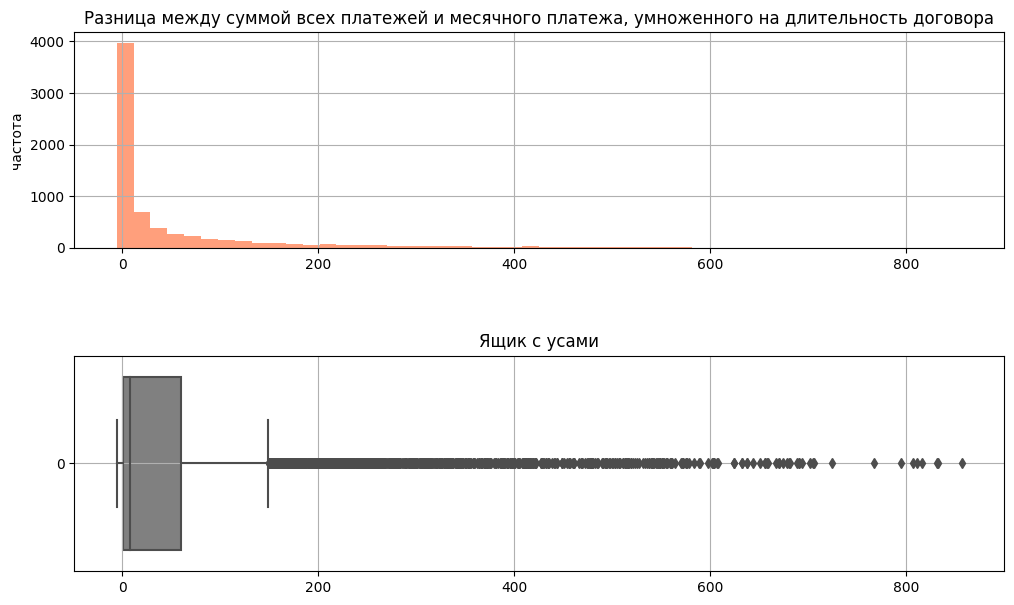

,count,mean,std,min,25%,50%,75%,max
0,7043.0,59.159421,113.677597,-5.478689,1.295492,7.803279,60.653115,857.161967


,count,mean,std,min,25%,50%,75%,max
total_charges,7043.0,2115.377573,2112.678861,19.05,436.75,1343.35,3236.69,9221.38


In [30]:
graph((data['total_charges'] - data['monthly_charges'] * data['duration']/30.5), 50, '', 'частота', 
      'Разница между суммой всех платежей и месячного платежа, умноженного на длительность договора', 'count', None, None)
to_describe(data['total_charges'])

- В большинстве случаев эти величины равны или близки к нулю, поэтому **можно смело удалять признак `total_charges`**:
    - верхняя граница значений, которые можем считать нормальными (не выбросы), на боксплоте - 149. Среднее разницы - 114. При том, что среднее значение `total_charges` - 2115, погрешность примерно 5%. 
    
    * *возможная причина таких разниц* - *какие-то дополнительные расходы, не связанные с месячными платежами, либо дорожание суммы месячных платежей.*

**Итог:**

Все указанные выше признаки можно удалять.

**Удаление выбранных признаков**

In [31]:
data = data.drop(['end_date', 'begin_date', 'total_charges', 'paperless_billing', 'gender'], axis=1)
data.shape

(7043, 16)

### Вывод

Созданы следующие признаки:
- целевой признак `ended` (1/0 - ушел ли клиент)
- время действия договора `duration`
- количество подключенных сервисов `services_nums`

Удалены следующие признаки:
- `TotalCharges`, `BeginDate` и `EndDate`, `personal`, `total_charges`.



<a id="5"></a> 
## Исследовательский анализ данных

### Непрерывные величины

Построим гистограммы распределения для непрерывных величин с разбивкой по таргету:

**duration**

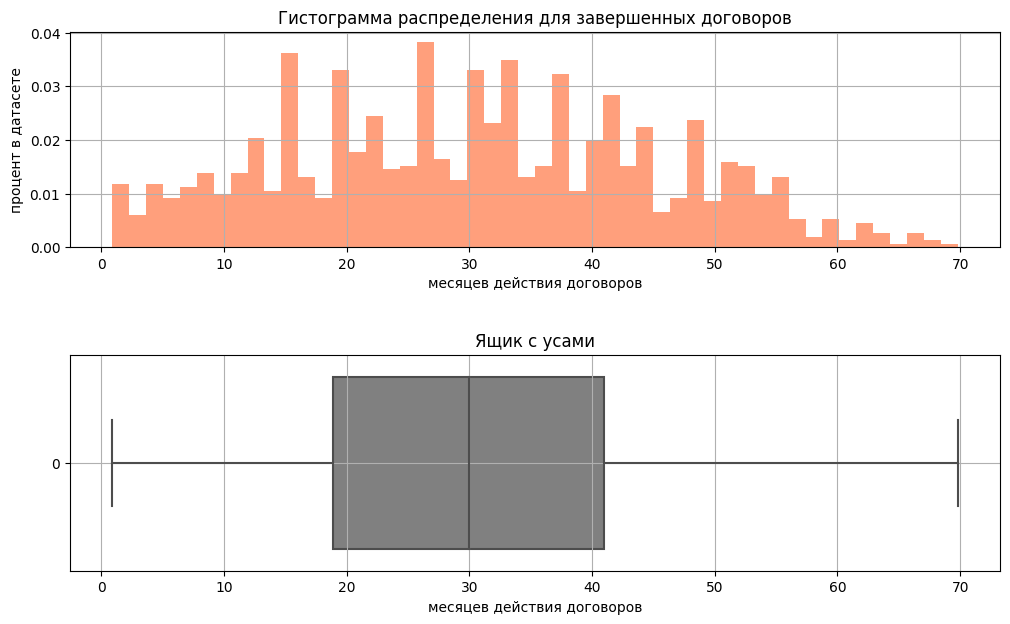

,count,mean,std,min,25%,50%,75%,max
duration,1101.0,30.323402,15.041682,0.918033,18.918033,30.0,40.95082,69.803279


In [32]:
graph(data.query('ended==1')['duration']/30.5, 50, 'месяцев действия договоров', 'процент в датасете', 
      'Гистограмма распределения для завершенных договоров', 'density', None, None)

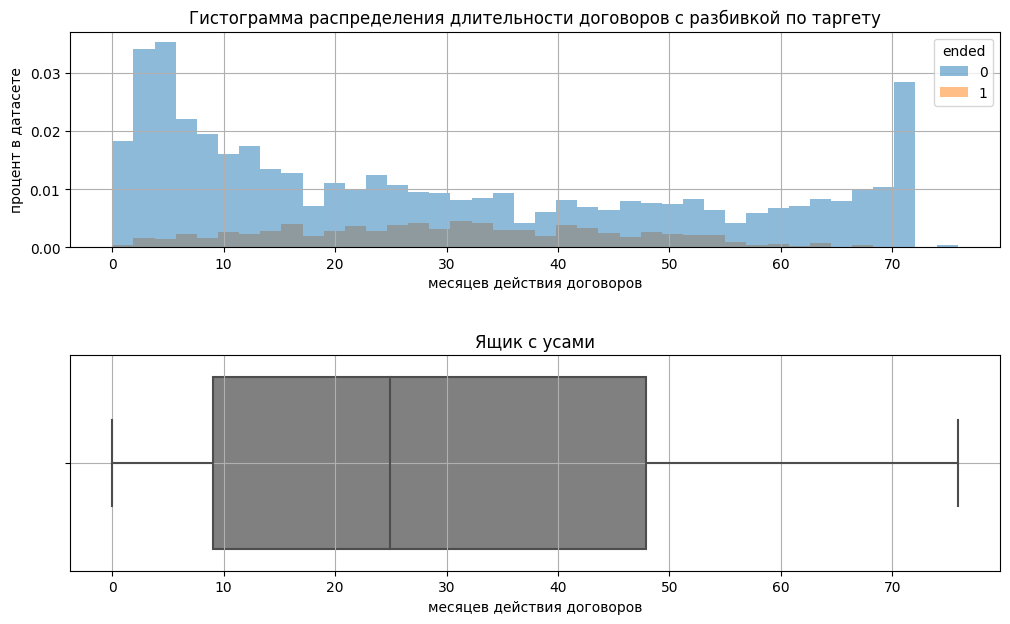

'не завершенные:'

,count,mean,std,min,25%,50%,75%,max
duration1,5942.0,29.301019,23.506838,0.0,8.032787,23.016393,49.934426,75.868852


'завершенные:'

,count,mean,std,min,25%,50%,75%,max
duration1,1101.0,30.323402,15.041682,0.918033,18.918033,30.0,40.95082,69.803279


In [33]:
data['duration1'] = data['duration']/30.5
graph(data, 40, 'месяцев действия договоров', 'процент в датасете', 
      'Гистограмма распределения длительности договоров с разбивкой по таргету', 'density', 'duration1', 'ended')

data = data.drop('duration1', axis=1)

Вывод:

- Медианное и среднее время договора выше у завершенных договоров.

- Также видим, что у завершенных договоров чуть ниже разброс.  
- А межквартильный размах значительно меньше - от 18.9 до 41 месяца (у действующих - от 8 до 50). Можно сказать, что наибольший риск ухода абонента возникает в эти месяцы - первая гистограмма наглядно показывает это.

- Примерно после 50 месяцев пользования процент ушедших клиентов спадает, а оставшихся - возрастает.

**monthly_charges**

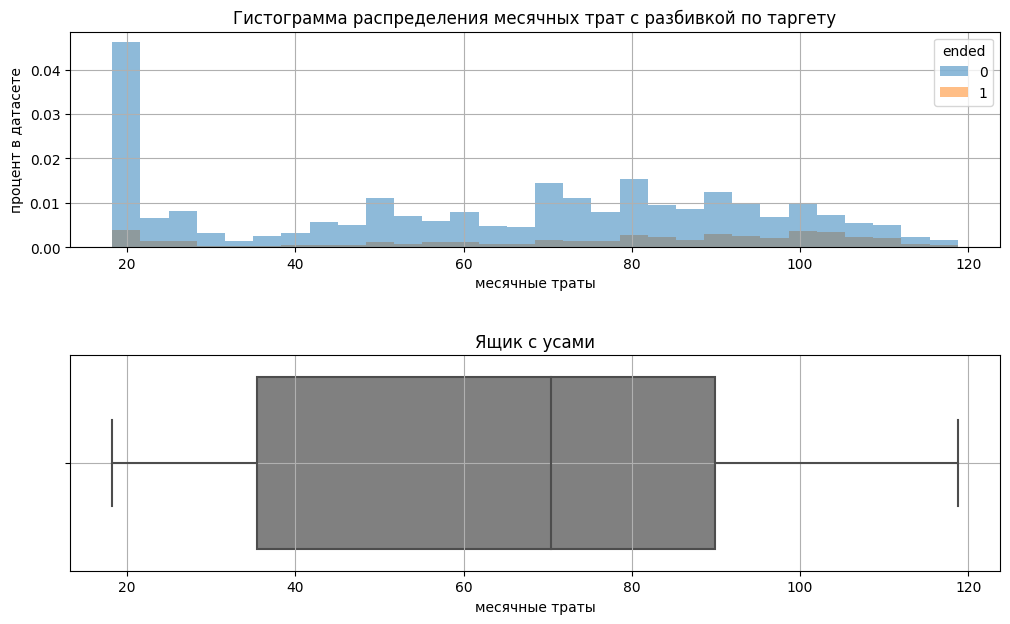

'не завершенные:'

,count,mean,std,min,25%,50%,75%,max
monthly_charges,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.6


'завершенные:'

,count,mean,std,min,25%,50%,75%,max
monthly_charges,1101.0,75.546004,29.116213,18.4,56.15,84.2,99.5,118.75


In [34]:
graph(data, 30, 'месячные траты', 'процент в датасете', 
      'Гистограмма распределения месячных трат с разбивкой по таргету', 'density', 'monthly_charges', 'ended')

Вывод:

- Ушедшие абоненты имели более высокие расходы за месяц - это хорошо видно на гистограмме, особенно начиная со значения 80.

- Среднее и медианное значения выше у ушедших клиентов - 75.5 и 84.2 против 62.8 и 69.2 соответственно.

- Разброс примерно одинаковый. Межквартильный размах снова чуть больше у текущих клиентов.

### Категориальные величины

Для таких величин построим сравнительные диаграммы и посмотрим, в каких долях распределены величины с разбивкой по таргету:

**Информация о договоре:**

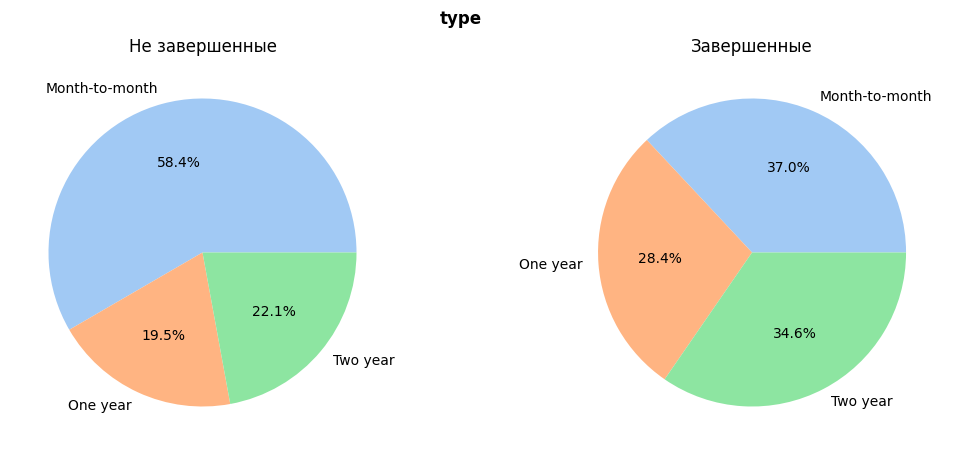

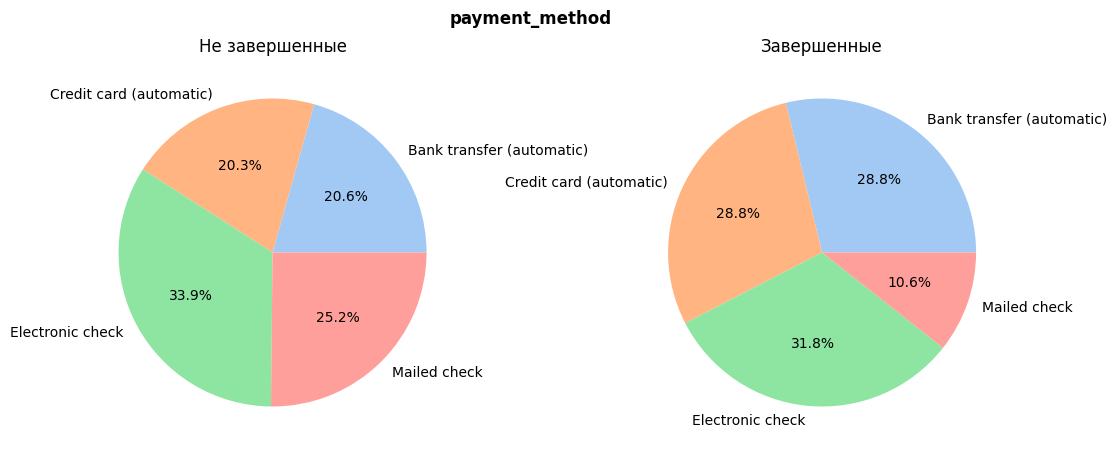

In [35]:
titles_for_pie=['Не завершенные', 'Завершенные']
for i in ['type', 'payment_method']:
    compare_pie(data.query('ended==0'), data.query('ended==1'), i)

Вывод:

Тип оплаты:
- Помесячная оплата значительно чаще встречается у клиентов с действующим договором. 
- Заметно чаще расторгали договор клиенты с оплатой раз в 1/2 года.

_________

Тип платежа:
- Среди действующих клиентов выше доля оплаты кредитной картой на 10%.  Доля Bank Transfer - ниже на 8%

_________

**Персональные данные:**

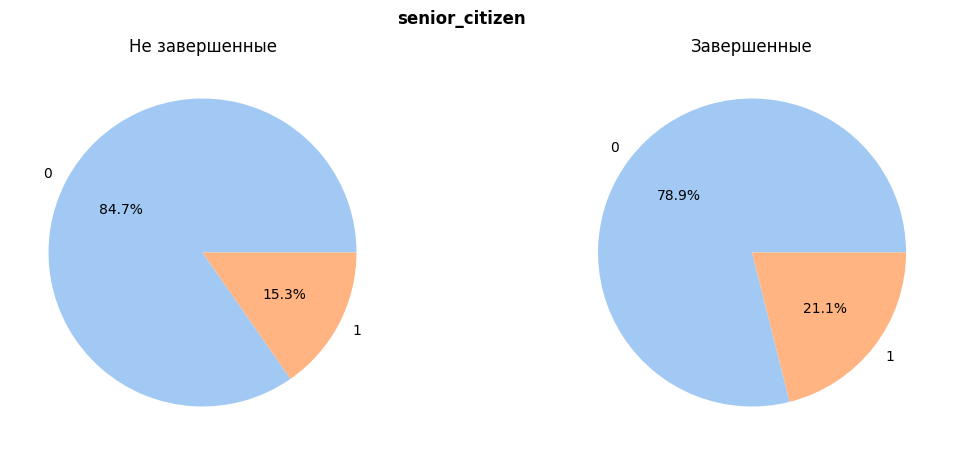

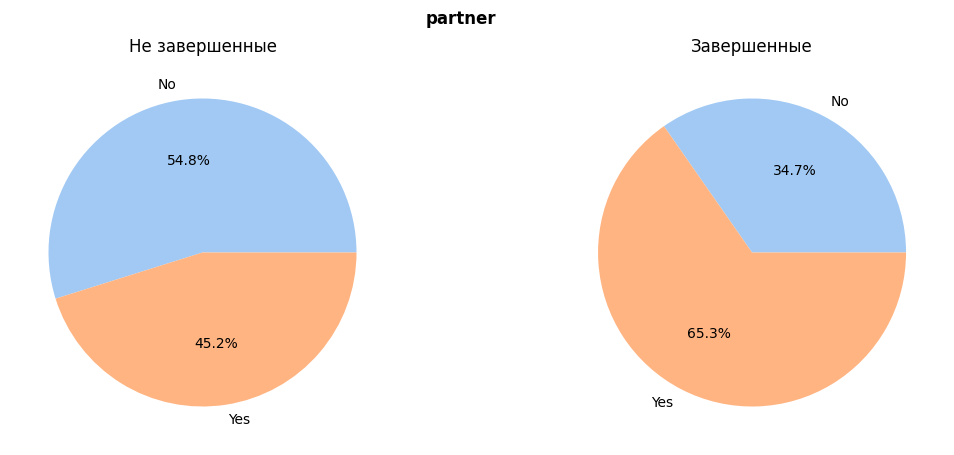

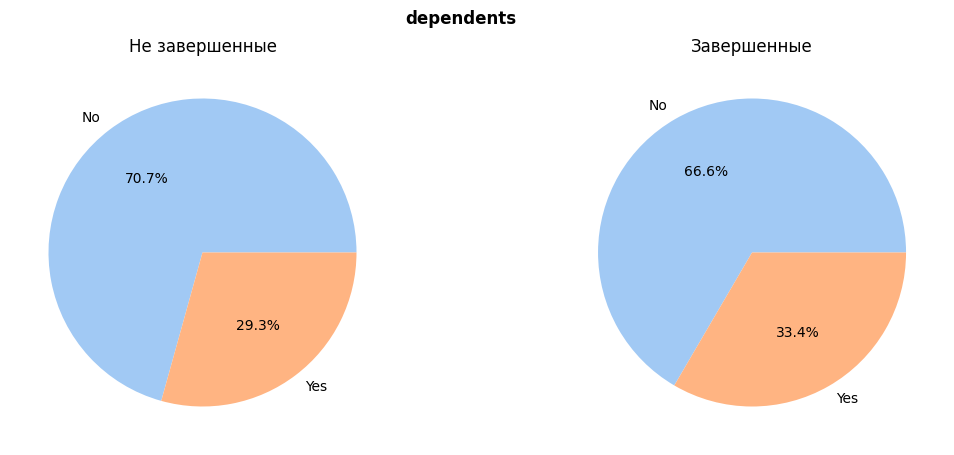

In [36]:
for i in ['senior_citizen', 'partner', 'dependents']:
    compare_pie(data.query('ended==0'), data.query('ended==1'), i)

Вывод:

Среди ушедших клиентов:
- Выше на 6% доля пенсионеров
- Реже на 10% есть супруг/супруга
- Незначительно чаще есть дети.

_____

**Информация об интернет услугах:**

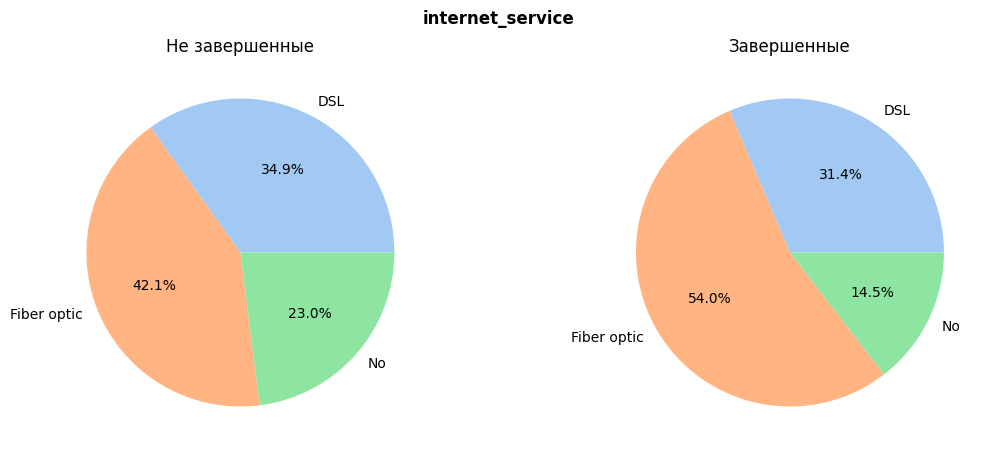

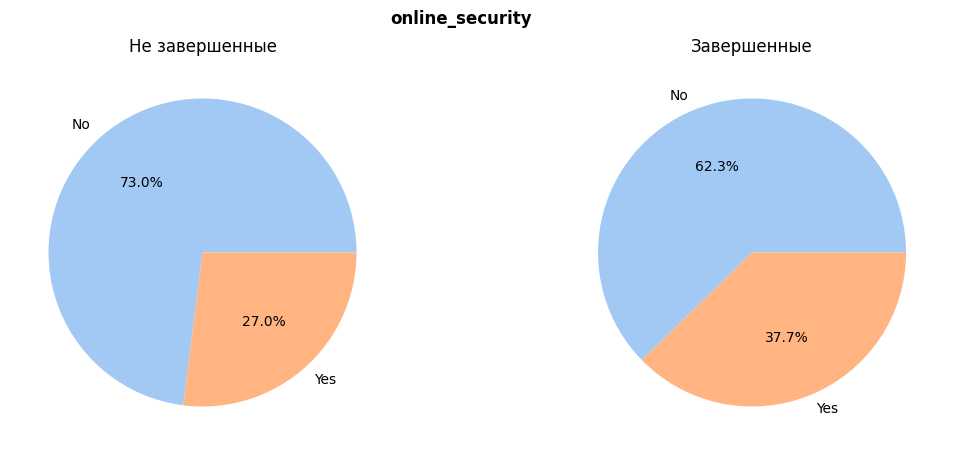

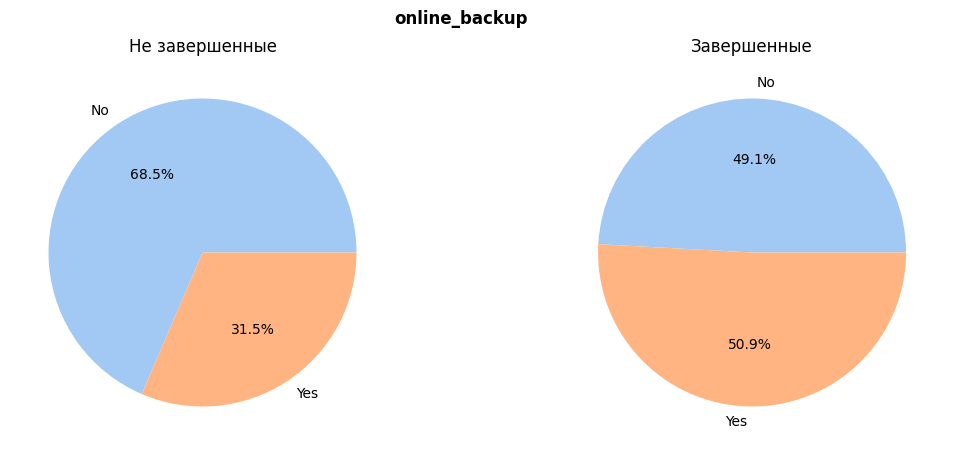

In [37]:
for i in ['internet_service', 'online_security', 'online_backup']:
    compare_pie(data.query('ended==0'), data.query('ended==1'), i)

Видим, что среди ушедших клиентов:
- выше доля типа подключения DSL, чем среди действующих, 
- чаще подключена опция блокировки опасных сайтов,

Облачное хранилище подключено у обоих типов клиентов в равных долях.

______

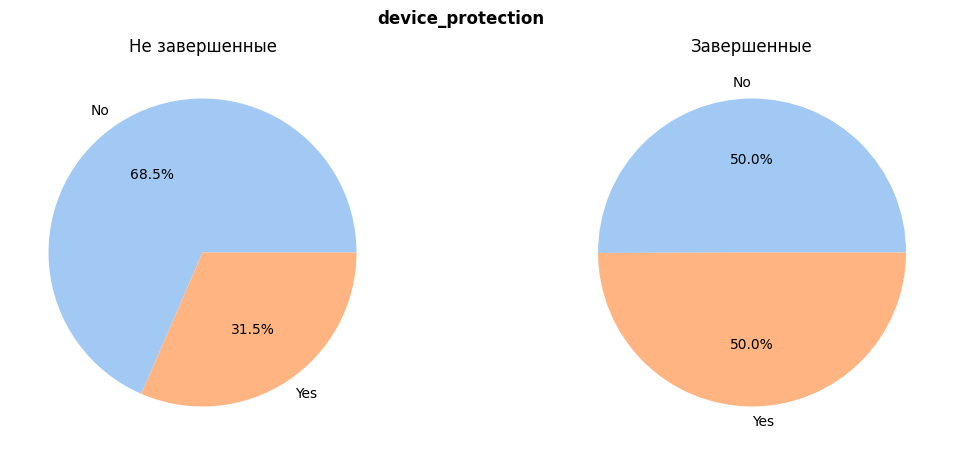

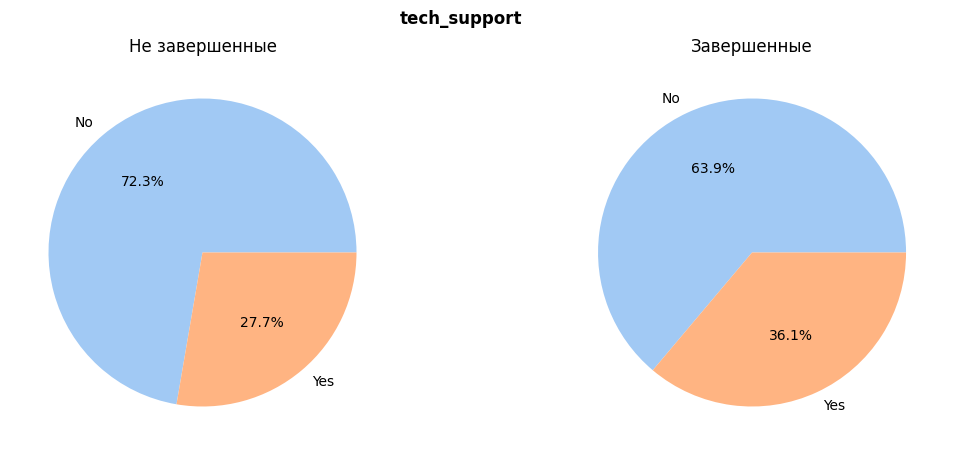

In [38]:
for i in ['device_protection', 'tech_support']:
    compare_pie(data.query('ended==0'), data.query('ended==1'), i)

- Наличие антивируса есть в равных долях у обоих типов клиентов.

- При этом у ушедших клиентов чаще была подключена техническая поддержка, чем у действующих.
______

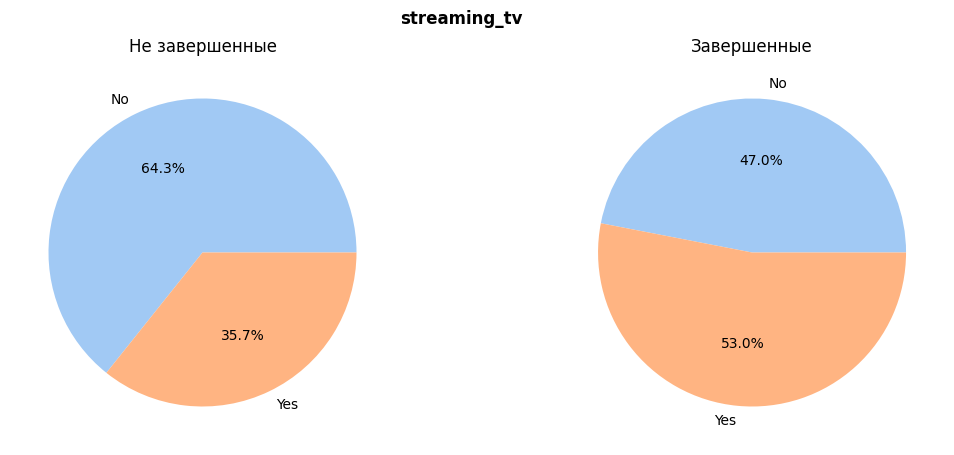

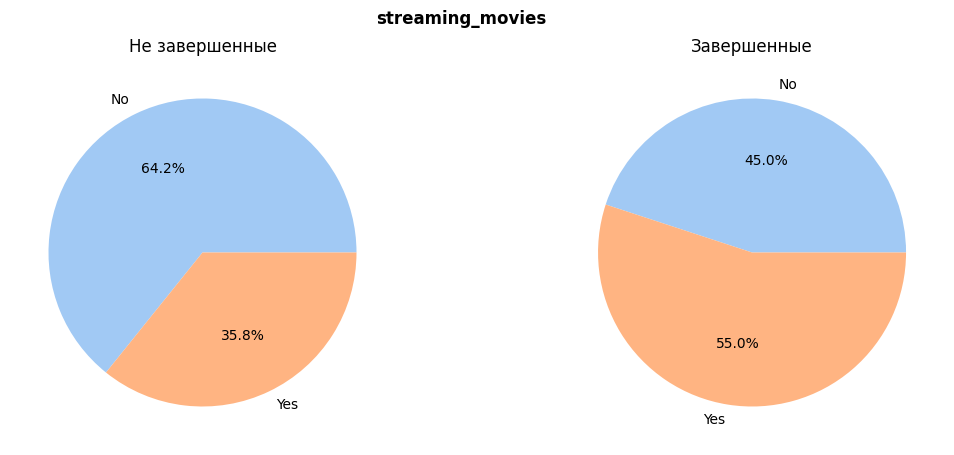

In [39]:
for i in ['streaming_tv', 'streaming_movies']:
    compare_pie(data.query('ended==0'), data.query('ended==1'), i)

- Клиенты с подключенным стриминговым телевидением и каталогом фильмов уходят реже.
______

**Телефония:**

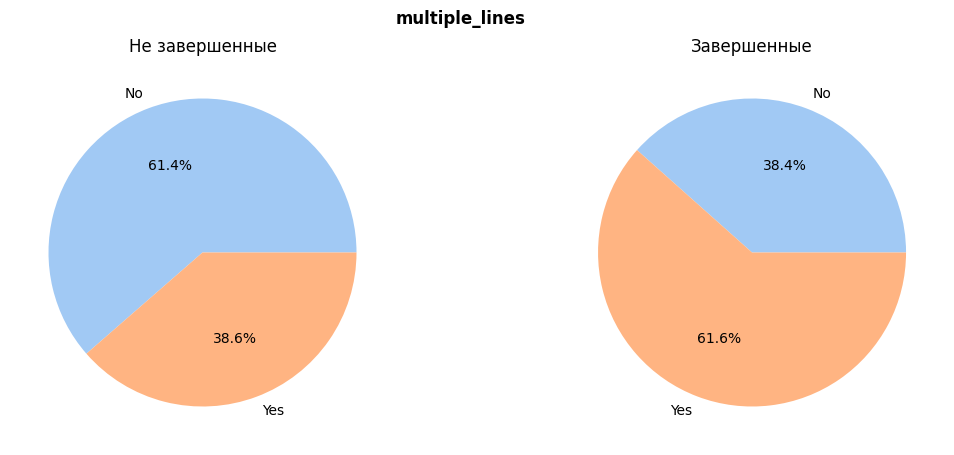

In [40]:
compare_pie(data.query('ended==0'), data.query('ended==1'), 'multiple_lines')

- Также подключение телефона к нескольким линиям одновременно - реже встречается у ушедших клиентов, чем у действующих.
______

### Целевой признак

In [41]:
data['ended'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: ended, dtype: float64

В датасете:
- 84,4% - действующие клиенты
- 15,6% - ушедшие клиенты

___

### Вывод

В результате исследовательского анализа данных с разбивкой по целевому признаку пришли к следующим выводам:

У ушедших клиентов, в сравнении с действующими:
- Время договора: Медианное и среднее выше, межквартильный размах значительно меньше, наибольший риск ухода абонента -  от 18.9 до 41 месяца, после 50 месяцев пользования процент ушедших клиентов спадает
- Расходы за месяц: более высокие расходы за месяц, среднее и медианное - 75.5 и 84.2, разброс примерно одинаковый, межквартильный размах снова чуть меньше.
- Помесячная оплата встречается значительно реже. (Заметно чаще расторгали договор клиенты с оплатой раз в 1/2 года.)
- Ниже доля оплаты кредитной картой на 10%. Доля Bank Transfer - выше на 8%.

Среди ушедших клиентов:
- Выше на 6% доля пенсионеров
- Реже на 10% есть супруг/супруга
- Незначительно чаще есть дети.

Также среди ушедших клиентов:
- выше доля типа подключения DSL
- чаще подключена опция блокировки опасных сайтов.
- Чаще была подключена техническая поддержка.

Также заметно, что клиенты с подключенным стриминговым телевидением и каталогом фильмов уходят реже.

<a id="6"></a> 
## Корреляционный анализ данных

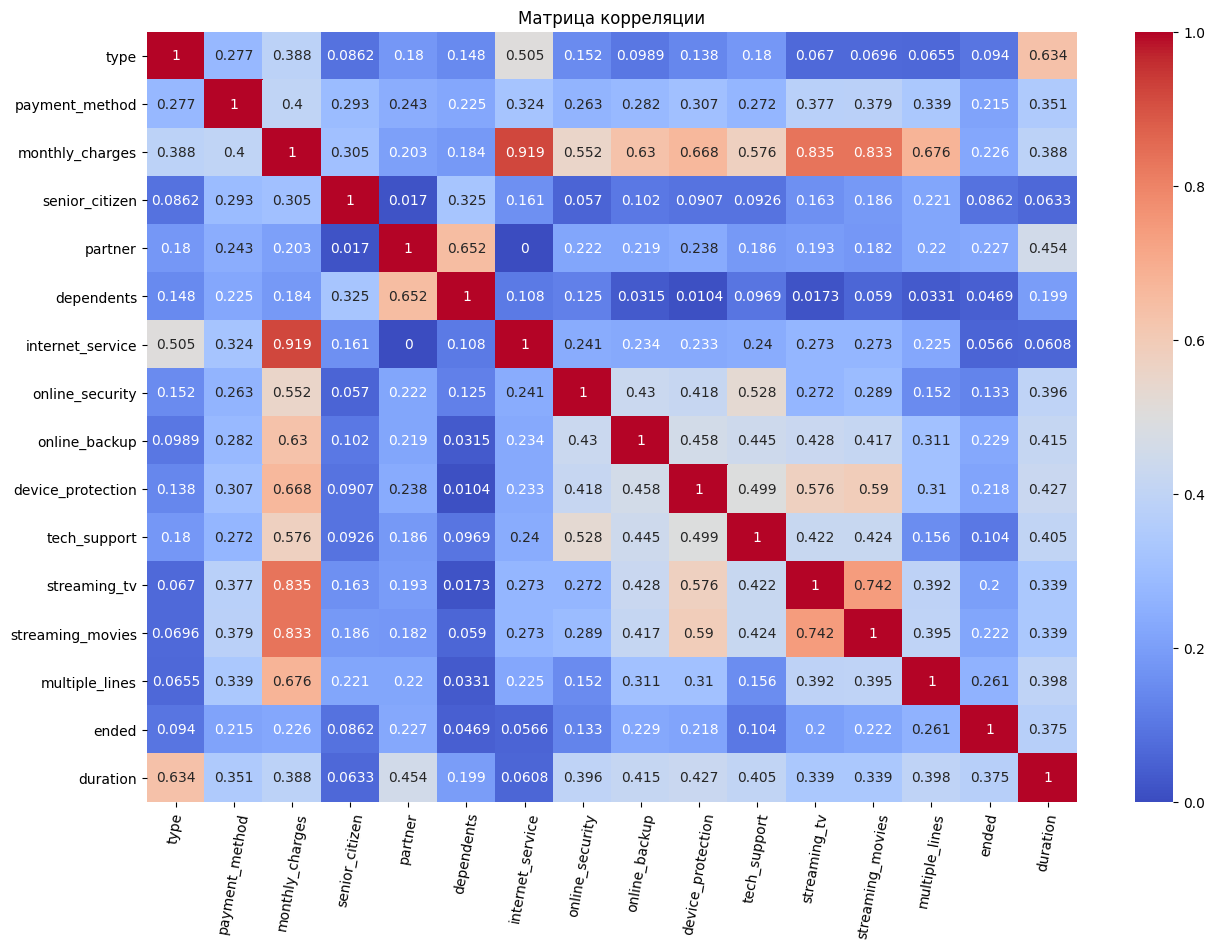

In [42]:
interval_cols = ['monthly_charges', 'duration']

figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Удалим признаки с мультиколлинеарностью (возьмем значения выше 0.8):
- Т.к. наибольшую корреляцию с таргетом среди них имеет признак `monthly_charges`, оставим именно его.

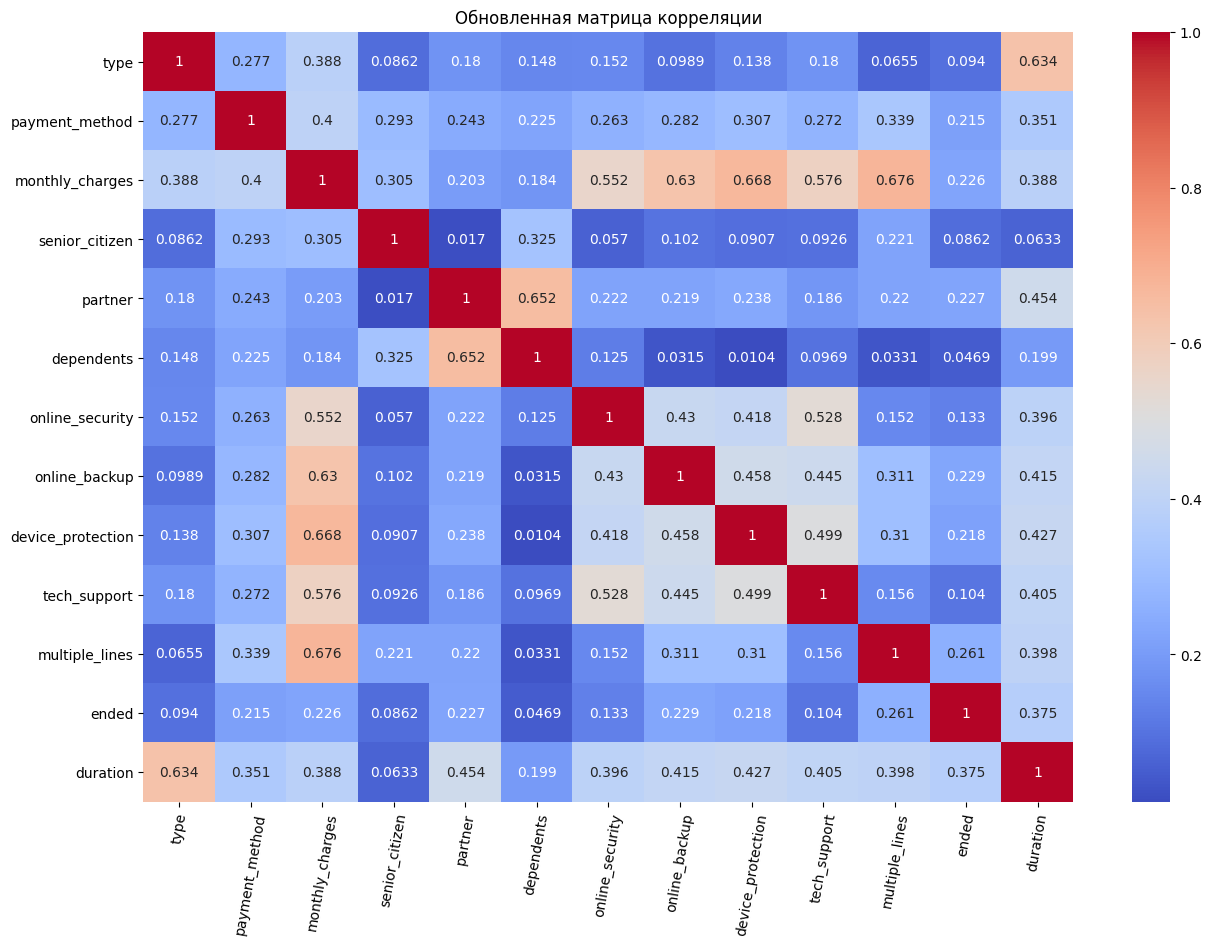

In [43]:
data = data.drop(['internet_service', 'streaming_tv', 'streaming_movies'], axis=1)

figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Обновленная матрица корреляции')
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Среди оставшихся признаков видим наиболее заметную (среднюю) корреляцию с целевым признаком у `duration`. Слабая, но заметная корреляция есть у признаков `payment_method`, `monthly_charges`, `partner`, `online_backup`, `device_protection`, `multiple_lines`. 

Оставшиеся признаки имеют корреляцию с целевым признаком в районе 0.1


### Вывод

Матрица корреляции указала на наличие большого количества признаков с мультиколлинеарностью. 

Для устранения проблемы были удалены следующие признаки:
- 'internet_service', 'streaming_tv', 'streaming_movies'

<a id="7"></a> 
## Подготовка данных 

### Разделение на train, test

Разбиваем на входные и целевой признаки:

In [44]:
X = data.drop('ended', axis=1)
y = data['ended']

Делим на тренировочную и тестовую выборки в соотношении 75:25.   
Используем стратификацию, чтобы значения таргета попали в выборки в равных долях:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

Проверяем размерности выборок:

In [46]:
print (X_train.shape, y_train.shape) 
print (X_test.shape, y_test.shape)

(5282, 12) (5282,)
(1761, 12) (1761,)


Проверяем, нет ли разницы в соотношении классов в выборках:

In [47]:
# модуль разниц процентных соотношений одного из классов в выборках меньше 0.1 процента
## (класс представлен в одной выборке менее чем на 0.1 процента реже или чаще, чем в другой)
if abs((y_train.value_counts(normalize=True) - y_test.value_counts(normalize=True))[0]) < 0.001:
    print ('Баланс классов соблюден')
else:
    print ('Баланс классов нарушен')

Баланс классов соблюден


### Пайплайн

Определим списки с категориальными и непрерывными величинами:

In [48]:
ohe_columns = list(X_train.drop(['monthly_charges', 'duration'], axis=1).columns)
num_columns = ['monthly_charges', 'duration']

Пайплайн:

In [49]:
# Кодирование категориальных величин
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

# Объединение шагов предподготовки
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    #('ord', ord_pipe, ord_columns), 
    ('num', StandardScaler(), num_columns)
], 
    remainder='passthrough'
)

# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Создадим датасеты с кодированными и масштабированными через пайплайн data_preprocessor признаками:

In [50]:
X_train_processed = data_preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(data=X_train_processed, columns=data_preprocessor.get_feature_names_out())

X_test_processed = data_preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(data=X_test_processed, columns=data_preprocessor.get_feature_names_out())

X_test_processed.head()

,ohe__type_One year,ohe__type_Two year,ohe__payment_method_Credit card (automatic),ohe__payment_method_Electronic check,ohe__payment_method_Mailed check,ohe__senior_citizen_1,ohe__partner_Yes,ohe__dependents_Yes,ohe__online_security_Yes,ohe__online_backup_Yes,ohe__device_protection_Yes,ohe__tech_support_Yes,ohe__multiple_lines_Yes,num__monthly_charges,num__duration
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,-0.007488,1.801085
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.141887,-0.736636
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.307341,-0.827269
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.506673,-0.378490
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.351758,-1.049466


### Вывод

Подготовка данных завершена:

1. Датасет разбит на тренировочную и тестовую выборки в соотношении 3 к 1, соблюден баланс классов
2. Определены списки категориальных и числовых величин
3. Построен и применен к датасетам пайплайн для кодирования и масштабирования признаков

<a id="8"></a> 
## Обучение моделей

Обучим разные модели. Для перебора параметров используем OptunaSearchCV как наиболее эффективный инструмент - более точный, чем RandomizedSearchCV и значительно более быстрый в сравнении с GridSearchCV.

### Logistic Regression

In [51]:
tuner_verbose = 0

model = LogisticRegression(random_state=RANDOM_STATE, penalty='l2', verbose=tuner_verbose)

parameters = {'solver': distributions.CategoricalDistribution(choices=('liblinear', 'lbfgs', 'newton-cg')),
              'C': distributions.FloatDistribution(0.1, 100)}

log_cv = OptunaSearchCV(model, 
                        parameters, 
                        cv=5, 
                        n_trials=10, 
                        scoring='roc_auc', 
                        random_state=RANDOM_STATE, 
                        n_jobs=-1, 
                        verbose=tuner_verbose)

log_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\282522814.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  log_cv = OptunaSearchCV(model,
[I 2025-03-29 04:10:27,514] A new study created in memory with name: no-name-7f723326-5364-4131-b7ad-0c87f662534f
[I 2025-03-29 04:10:27,896] Trial 0 finished with value: 0.7473232995294935 and parameters: {'solver': 'liblinear', 'C': 63.928965433830136}. Best is trial 0 with value: 0.7473232995294935.
[I 2025-03-29 04:10:27,903] Trial 2 finished with value: 0.7473067459520841 and parameters: {'solver': 'liblinear', 'C': 1.3559880493933707}. Best is trial 0 with value: 0.7473232995294935.
[I 2025-03-29 04:10:28,140] Trial 3 finished with value: 0.7473354678960633 and parameters: {'solver': 'lbfgs', 'C': 44.519445230975364}. Best is trial 3 with value: 0.7473354678960633.
[I 2025-03-29 04:10:28,247] Trial 5 finished with value: 0.7473273776954596 and parameters: {'solver': '

OptunaSearchCV(cv=5, estimator=LogisticRegression(random_state=100225),
               n_jobs=-1,
               param_distributions={'C': FloatDistribution(high=100.0, log=False, low=0.1, step=None),
                                    'solver': CategoricalDistribution(choices=('liblinear', 'lbfgs', 'newton-cg'))},
               random_state=100225, scoring='roc_auc')

In [52]:
print ('Лучшая модель и её параметры:\n\n', log_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(log_cv.best_score_, 3))

Лучшая модель и её параметры:

 LogisticRegression(C=68.337562841012, random_state=100225)

Метрика лучшей модели при кросс-валидации: 0.747


**Лучшая модель логистической регрессии:**
- **LogisticRegression(C=74.66873814303104, random_state=100225)**
- **ROC-AUC = 0.747**

### SVC

In [53]:
model = SVC(random_state=RANDOM_STATE, probability=True)

parameters = {'kernel': distributions.CategoricalDistribution(choices=('rbf', 'poly')),
              'C': distributions.FloatDistribution(0.1, 10)}

svc_cv = OptunaSearchCV(model, 
                        parameters, 
                        cv=5, 
                        n_trials=10, 
                        scoring='roc_auc', 
                        random_state=RANDOM_STATE)

svc_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\3980295894.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  svc_cv = OptunaSearchCV(model,
[I 2025-03-29 04:10:29,095] A new study created in memory with name: no-name-eff2fbf4-c503-44ca-b4c5-567102fc5e0d
[I 2025-03-29 04:10:53,220] Trial 0 finished with value: 0.7593731535768798 and parameters: {'kernel': 'rbf', 'C': 5.538630297399507}. Best is trial 0 with value: 0.7593731535768798.
[I 2025-03-29 04:11:15,586] Trial 1 finished with value: 0.7623492815251943 and parameters: {'kernel': 'rbf', 'C': 1.6880159438129712}. Best is trial 1 with value: 0.7623492815251943.
[I 2025-03-29 04:11:36,520] Trial 2 finished with value: 0.7587737225859712 and parameters: {'kernel': 'rbf', 'C': 5.8866878666030855}. Best is trial 1 with value: 0.7623492815251943.
[I 2025-03-29 04:12:02,154] Trial 3 finished with value: 0.7460200102816117 and parameters: {'kernel': 'poly', 'C': 8.

OptunaSearchCV(cv=5, estimator=SVC(probability=True, random_state=100225),
               n_jobs=1,
               param_distributions={'C': FloatDistribution(high=10.0, log=False, low=0.1, step=None),
                                    'kernel': CategoricalDistribution(choices=('rbf', 'poly'))},
               random_state=100225, scoring='roc_auc')

In [54]:
print ('Лучшая модель и её параметры:\n\n', svc_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(svc_cv.best_score_, 3))

Лучшая модель и её параметры:

 SVC(C=1.6880159438129712, probability=True, random_state=100225)

Метрика лучшей модели при кросс-валидации: 0.762


**Лучшая модель SVC:**
- **SVC(C=1.6880159438129712, probability=True, random_state=100225)**
- **ROC-AUC - 0.762**

### KNeighborsClassifier

In [55]:
model = KNeighborsClassifier()

parameters = {'n_neighbors': distributions.IntDistribution(1, 300)}

neighbors_cv = OptunaSearchCV(model, 
                        parameters, 
                        cv=5, 
                        n_trials=10, 
                        scoring='roc_auc', 
                        random_state=RANDOM_STATE)

neighbors_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\735668322.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  neighbors_cv = OptunaSearchCV(model,
[I 2025-03-29 04:14:33,071] A new study created in memory with name: no-name-7c71cf5e-64d9-4b92-9de3-54bc96e0fe70
[I 2025-03-29 04:14:35,382] Trial 0 finished with value: 0.7954962188030212 and parameters: {'n_neighbors': 246}. Best is trial 0 with value: 0.7954962188030212.
[I 2025-03-29 04:14:37,742] Trial 1 finished with value: 0.7964826472138176 and parameters: {'n_neighbors': 204}. Best is trial 1 with value: 0.7964826472138176.
[I 2025-03-29 04:14:39,891] Trial 2 finished with value: 0.8008076229143214 and parameters: {'n_neighbors': 165}. Best is trial 2 with value: 0.8008076229143214.
[I 2025-03-29 04:14:41,573] Trial 3 finished with value: 0.8019619115079145 and parameters: {'n_neighbors': 124}. Best is trial 3 with value: 0.8019619115079145.
[I 2025-03-29 04

OptunaSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
               param_distributions={'n_neighbors': IntDistribution(high=300, log=False, low=1, step=1)},
               random_state=100225, scoring='roc_auc')

In [56]:
print ('Лучшая модель и её параметры:\n\n', neighbors_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(neighbors_cv.best_score_, 3))

Лучшая модель и её параметры:

 KNeighborsClassifier(n_neighbors=75)

Метрика лучшей модели при кросс-валидации: 0.804


**Лучший результат метода ближаших соседей:**
- **KNeighborsClassifier(n_neighbors=75)**
- **ROC-AUC = 0.8**

### DecisionTreeClassifier

In [57]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {'min_samples_split': distributions.IntDistribution(2, 70),
              'min_samples_leaf': distributions.IntDistribution(1, 70),
             'max_depth': distributions.IntDistribution(2, 70),
             'max_features': distributions.IntDistribution(2, 12)}

decision_tree_cv = OptunaSearchCV(model, parameters, cv=5, n_trials=20, scoring='roc_auc', random_state=RANDOM_STATE)

decision_tree_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\3272356547.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  decision_tree_cv = OptunaSearchCV(model, parameters, cv=5, n_trials=20, scoring='roc_auc', random_state=RANDOM_STATE)
[I 2025-03-29 04:14:49,844] A new study created in memory with name: no-name-94f856ee-7a24-4616-8c3e-07cefafa1bcc
[I 2025-03-29 04:14:49,992] Trial 0 finished with value: 0.7594728273620059 and parameters: {'min_samples_split': 58, 'min_samples_leaf': 48, 'max_depth': 39, 'max_features': 6}. Best is trial 0 with value: 0.7594728273620059.
[I 2025-03-29 04:14:50,143] Trial 1 finished with value: 0.7486330513277764 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 12, 'max_depth': 32, 'max_features': 4}. Best is trial 0 with value: 0.7594728273620059.
[I 2025-03-29 04:14:50,264] Trial 2 finished with value: 0.7702137207891246 and parameters: {'min_samples_split': 42, 'min_sample

OptunaSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100225),
               n_jobs=1, n_trials=20,
               param_distributions={'max_depth': IntDistribution(high=70, log=False, low=2, step=1),
                                    'max_features': IntDistribution(high=12, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=70, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=70, log=False, low=2, step=1)},
               random_state=100225, scoring='roc_auc')

In [58]:
print ('Лучшая модель и её параметры:\n\n', decision_tree_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(decision_tree_cv.best_score_, 3))

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=49, max_features=11, min_samples_leaf=58,
                       min_samples_split=45, random_state=100225)

Метрика лучшей модели при кросс-валидации: 0.793


**Дерево решений, лучшая модель:**
- **DecisionTreeClassifier(max_depth=49, max_features=11, min_samples_leaf=58, min_samples_split=45, random_state=100225)**
- **ROC-AUC - 0.793**

### CatBoostClassifier

In [59]:
model = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='AUC', logging_level='Silent')

parameters = {'iterations' : distributions.IntDistribution(200, 500),
        'learning_rate': distributions.FloatDistribution(0.03, 0.6),
        'l2_leaf_reg': distributions.IntDistribution(5, 20),
        'depth': distributions.IntDistribution(1, 16)
    }  

catboost_cv = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='roc_auc', random_state=RANDOM_STATE)

catboost_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\1888388872.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  catboost_cv = OptunaSearchCV(model, parameters, cv=3, n_trials=5, scoring='roc_auc', random_state=RANDOM_STATE)
[I 2025-03-29 04:14:55,556] A new study created in memory with name: no-name-cbaa62a5-5b27-42d1-b2a4-0f8bb426a5bb
[I 2025-03-29 04:15:06,665] Trial 0 finished with value: 0.8874906167422641 and parameters: {'iterations': 446, 'learning_rate': 0.415839266069728, 'l2_leaf_reg': 13, 'depth': 7}. Best is trial 0 with value: 0.8874906167422641.
[I 2025-03-29 04:15:11,505] Trial 1 finished with value: 0.8708133928452781 and parameters: {'iterations': 227, 'learning_rate': 0.12143122100741348, 'l2_leaf_reg': 12, 'depth': 4}. Best is trial 0 with value: 0.8874906167422641.
[I 2025-03-29 04:22:31,423] Trial 2 finished with value: 0.8501726745662723 and parameters: {'iterations': 375, 'learning_rate': 0

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostClassifier object at 0x0000013E40204580>,
               n_jobs=1, n_trials=5,
               param_distributions={'depth': IntDistribution(high=16, log=False, low=1, step=1),
                                    'iterations': IntDistribution(high=500, log=False, low=200, step=1),
                                    'l2_leaf_reg': IntDistribution(high=20, log=False, low=5, step=1),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.03, step=None)},
               random_state=100225, scoring='roc_auc')

In [60]:
print ('Лучшая модель и её параметры:\n\n', catboost_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(catboost_cv.best_score_, 3))

Лучшая модель и её параметры:


Метрика лучшей модели при кросс-валидации: 0.887


**Лучшая модель:**
- **CatboostClassifier('iterations': 446, 'learning_rate': 0.415839266069728, 'l2_leaf_reg': 13, 'depth': 7)**
- **ROC-AUC: 0.894**

### LightGBM

In [61]:
model = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, metric='binary_error', verbosity= -1)

parameters = {'n_estimators': optuna.distributions.IntDistribution(50, 200),
              'learning_rate': optuna.distributions.FloatDistribution(0.01, 1.0), 
              'max_depth': distributions.IntDistribution(4, 16)
             }

lgbm_cv = OptunaSearchCV(model,
                         parameters,
                         scoring='roc_auc',
                         cv=5,
                         n_trials=10, 
                         random_state=RANDOM_STATE)

lgbm_cv.fit(X_train_processed, y_train)

C:\Users\Денис\AppData\Local\Temp\ipykernel_1608\473888863.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgbm_cv = OptunaSearchCV(model,
[I 2025-03-29 05:04:24,661] A new study created in memory with name: no-name-9ddbc921-97ac-4eaa-89a5-d2c96252c8e9
[I 2025-03-29 05:04:27,828] Trial 0 finished with value: 0.8776184172806236 and parameters: {'n_estimators': 173, 'learning_rate': 0.6801418831737382, 'max_depth': 11}. Best is trial 0 with value: 0.8776184172806236.
[I 2025-03-29 05:04:30,025] Trial 1 finished with value: 0.8713364481464685 and parameters: {'n_estimators': 112, 'learning_rate': 0.10097086807235417, 'max_depth': 6}. Best is trial 0 with value: 0.8776184172806236.
[I 2025-03-29 05:04:31,949] Trial 2 finished with value: 0.883089201458365 and parameters: {'n_estimators': 116, 'learning_rate': 0.2570848841386553, 'max_depth': 11}. Best is trial 2 with value: 0.883089201458365.
[I 2025-03-29 05:04:

OptunaSearchCV(cv=5,
               estimator=LGBMClassifier(metric='binary_error', n_jobs=-1,
                                        random_state=100225, verbosity=-1),
               n_jobs=1,
               param_distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None),
                                    'max_depth': IntDistribution(high=16, log=False, low=4, step=1),
                                    'n_estimators': IntDistribution(high=200, log=False, low=50, step=1)},
               random_state=100225, scoring='roc_auc')

In [62]:
print ('Лучшая модель и её параметры:\n\n', lgbm_cv.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round(lgbm_cv.best_score_, 3))

Лучшая модель и её параметры:

 LGBMClassifier(learning_rate=0.5440059873416397, max_depth=4,
               metric='binary_error', n_estimators=82, n_jobs=-1,
               random_state=100225, verbosity=-1)

Метрика лучшей модели при кросс-валидации: 0.898


**Лучший результат:**
- **LGBMClassifier(learning_rate=0.5440059873416397, max_depth=4, metric='binary_error', n_estimators=82, n_jobs=-1,random_state=100225, verbosity=-1)**
- **ROC-AUC: 0.898**

### Вывод

Модели успешно обучены. Лучшие:
- LogisticRegression(C=87.32223052945378, random_state=100225)
- SVC(C=0.17731446909323245, kernel='poly', probability=True, random_state=100225)
- KNeighborsClassifier(n_neighbors=75)
- DecisionTreeClassifier(max_depth=49, max_features=11, min_samples_leaf=58, min_samples_split=45, random_state=100225)
- CatboostClassifier('iterations': 446, 'learning_rate': 0.415839266069728, 'l2_leaf_reg': 13, 'depth': 7)
- LGBMClassifier(learning_rate=0.5440059873416397, max_depth=4, metric='binary_error', n_estimators=82, n_jobs=-1,random_state=100225, verbosity=-1)


<a id="9"></a> 
## Анализ результатов лучшей модели

### Выбор лучшей модели

Сравним результаты лучших моделей по значениям метрики ROC_AUC, которые получили на кросс-валидациях:

In [63]:
names = ['log_cv', 'svc_cv', 'neighbors_cv', 'decision_tree_cv', 'catboost_cv', 'lgbm_cv']
values = []
for i in [log_cv, svc_cv, neighbors_cv, decision_tree_cv, catboost_cv, lgbm_cv]:
    values.append(i.best_score_)

pd.DataFrame(values, index=names, columns=['roc_auc'])

,roc_auc
log_cv,0.747342
svc_cv,0.762349
neighbors_cv,0.804180
decision_tree_cv,0.793330
catboost_cv,0.887491
lgbm_cv,0.897786


Логистическая регрессия показала себя довольно слабо - 0.74.  Чуть лучше - SVC, 0.77.

KNeighborsClassifier, DecisionTreeClassifier достигли метрики ROC-AUC около 0.8. Тем не менее, это меньше ожидаемого результата 0.85.

Лучшими оказались модели LGMClassifier и CatBoostClassifier - 0.898 и 0.887 соответственно.

**Выбор модели:**
- **Для дальнейшей работы берем модель LGMClassifier, т.к. она показала лучший результат и более высокую, в сравнении с CatBoost, скорость обучения.**

### Результаты на тестовой выборке 

**ROC-AUC**

In [64]:
prediction = lgbm_cv.best_estimator_.predict(X_test_processed)
pred_proba = lgbm_cv.best_estimator_.predict_proba(X_test_processed)[:, 1]

roc_auc_test = roc_auc_score(y_test, pred_proba)
accuracy_scored = accuracy_score(y_test, prediction)

print ('Метрики лучшей модели на тестовой выборке:\n')
print ('ROC-AUC =', roc_auc_test.round(3))

print ('accuracy=', round(accuracy_scored, 3))

Метрики лучшей модели на тестовой выборке:

ROC-AUC = 0.92
accuracy= 0.918


- Очень хороший результат.  
 **ROC-AUC = 0.92**
 
 Также высокая точность - в почти в 92% случаев предсказания модели верны.

**ROC-AUC curve**

Построим ROC-кривую:

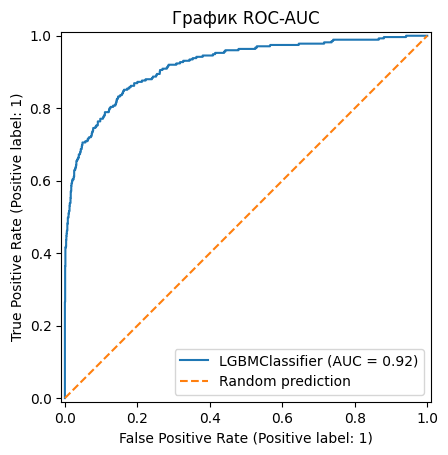

In [65]:
RocCurveDisplay.from_estimator(lgbm_cv.best_estimator_, X_test_processed, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title('График ROC-AUC')
plt.legend()
plt.show()

- Кривая покрывает большую часть площади. В основном модель предсказывает значения целевой переменной правильно.
- Тем не менее, кривая не очень резко меняет наклон. Наивысший TPR при низкой FPR - в районе 0.85.

**Precision, Recall, Confusion_matrix**

Precision:  0.86
Recall:  0.57


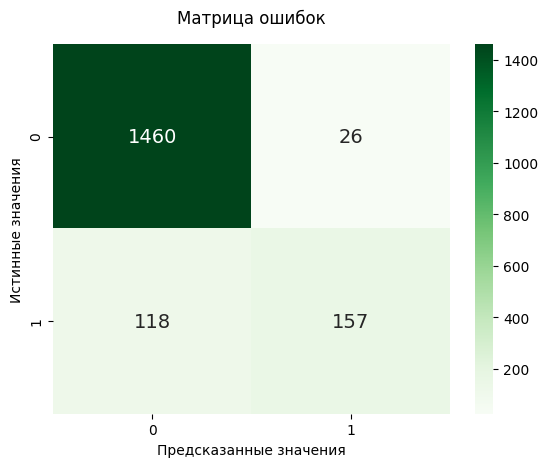

In [66]:
print ('Precision: ', round(precision_score(y_test, prediction), 2))
print ('Recall: ', round(recall_score(y_test, prediction), 2))

cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

- Достаточно высокая точность определения первого класса (ушедшие клиенты) - в 85% случаев клиент, помеченный моделью как ушедший, действительно таким является
- При этом модель находит всего 57% ушедших абонентов.
- По матрице ошибок видим, что среди ушедших клиентов модель верно классифицировала 157 и упустила 118.

### Анализ важности признаков

С помощью SHAP посмотрим, как признаки влияют на целевую переменную (уход абонента):

C:\anaconda3\envs\practicum\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


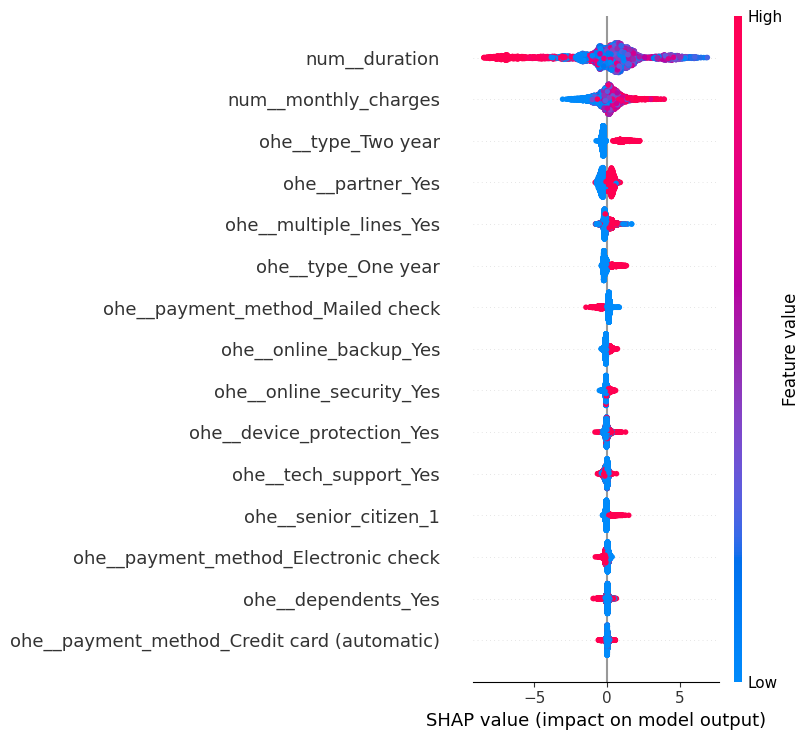

In [67]:
shap_values = shap.TreeExplainer(lgbm_cv.best_estimator_).shap_values(X_train_processed)
shap.summary_plot(shap_values, X_train_processed, max_display=20)

**Вывод:**

Понижают риск ухода абонента:
- Долгое пользование услугами
- Низкая стоимость за месяц
- Помесячная оплата
- Методы оплаты - Чек по почте и электронный чек

Повышенный риск ухода абонента:
- Высокие расходы за услуги за месяц
- Оплата раз в год / раз в два года
- Наличие супруги/супруга
- Пенсионеры
- Подключенные антивирус, блокировка опасных сайтов и облачное хранилище

### Вывод

Для дальнейшей работы взяли модель LGMClassifier, т.к. она показала лучший результат и чуть более высокую, в сравнении с CatBoost, скорость обучения.

Результаты на тестовой выборке:
- ROC-AUC = 0.92
- Accuracy 91.7%

ROC-кривая:
- Кривая покрывает большую часть площади. В основном модель предсказывает значения целевой переменной правильно.
- Тем не менее, кривая не очень резко меняет наклон. Наивысший TPR при низкой FPR - в районе 0.85.

Другие метрики:
- Precision:  0.85
- Recall:  0.57
- По матрице ошибок видим, что среди ушедших клиентов модель верно классифицировала 157 и упустила 118.

Анализ важности признаков:

- Понижают риск ухода абонента:
    - Долгое пользование услугами
    - Низкая стоимость за месяц
    - Помесячная оплата
    - Методы оплаты - Чек по почте и электронный чек

- Повышенный риск ухода абонента:
    - Высокие расходы за услуги за месяц
    - Оплата раз в год / раз в два года
    - Наличие супруги/супруга
    - Пенсионеры
    - Подключенные антивирус, блокировка опасных сайтов и облачное хранилище
    

<a id="10"></a> 
### Выводы для бизнеса

Определим, как модель сможет поспособствовать снижению потерь бизнеса.

Для этого объединим в таблицу со входными тестовыми признаками реальные и предсказанные значения целевой переменной и посчитаем, сколько процентов дохода можно сохранить при различных значениях предлагаемых скидок и положительных откликов на них со стороны клиентов.

#### При пороге классификации 0.5

In [68]:
test_joined = X_test.join(y_test, on=X_test.index)
test_joined['preds'] = prediction
full_sum = test_joined['monthly_charges'].sum()

print ('Сумма, которую ежемесячно приносят сервису клиенты тестовой выборки: \n', full_sum)

Сумма, которую ежемесячно приносят сервису клиенты тестовой выборки: 
 111863.5


Посчитаем, какую сумму ежемесячно приносят разные клиенты:

In [69]:
# Абоненты класса 1 (ушедшие)
all_loses = test_joined.query('ended==1')['monthly_charges'].sum()

# абоненты класса 1, которых модель отнесла к классу 1
definded_loses = test_joined.query('preds==1 and preds==ended')['monthly_charges'].sum().round(2)

# действующие клиенты (0), которых модель пометила как ушедших (1):
uncorrect_1 = test_joined.query('preds==1 and preds!=ended')['monthly_charges'].sum().round(2)

print ('Суммы ежемесячных подписок:')
print ('- Класс 1: ', all_loses)
print ('- Класс 1 определенный как 1: ', definded_loses)
print ('- Класс 0 определенный как 1: ', uncorrect_1)

Суммы ежемесячных подписок:
- Класс 1:  21089.35
- Класс 1 определенный как 1:  12529.6
- Класс 0 определенный как 1:  1506.7


Процент дохода, сохранившийся сервисом при уходе клиентов класса 1:

In [70]:
all_loses_saved_percent = ((full_sum - all_loses)/full_sum*100).round(2)
all_loses_saved_percent

81.15

- процент ежемесячного дохода, оставшийся у провайдера при условии ухода всех клиентов класса 1 (ушедшие) и без учета привлечения новых клиентов.

Построим таблицу, в которой посчитаем процент сохранившегося дохода при условиях:
- скидки от 5% до 90%
- процент клиентов, оставшихся после предложения скидки, 10-25-50-75%
- с учетом ошибочно отнесенных к классу 1 (ушедшие) клиентов, не собиравшихся уходить, но согласившихся на скидку.

In [71]:
discounts = np.arange(0.05, 0.90, 0.01)

saved = pd.DataFrame(discounts, columns=['discount'])
saved['discount%'] = saved['discount']*100

# процент дохода, сохранившегося у провайдера, с учетом: 
# что Х% уходящих пользователей согласятся остаться на условиях предложенной скидки
# что клиенты, изначально не планировавшие уходить, также согласятся на скидку
saved['10%'] = (
    (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.1 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

saved['25%'] = (
    (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.25 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

saved['50%'] = (
    (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.5 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

saved['75%'] = (
    (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.75 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

# константа - сохраненный процент дохода при условии ухода всех клиентов класса 1
saved['no_discount_saved'] = all_loses_saved_percent

saved.head(3)

,discount,discount%,10%,25%,50%,75%,no_discount_saved
0,0.05,5.0,82.14,83.74,86.40,89.06,81.15
1,0.06,6.0,82.12,83.70,86.33,88.96,81.15
2,0.07,7.0,82.09,83.66,86.26,88.87,81.15


Визуализируем, как меняется процент сохраненного дохода в зависимости от скидки и вероятности отклика на предложение остаться:

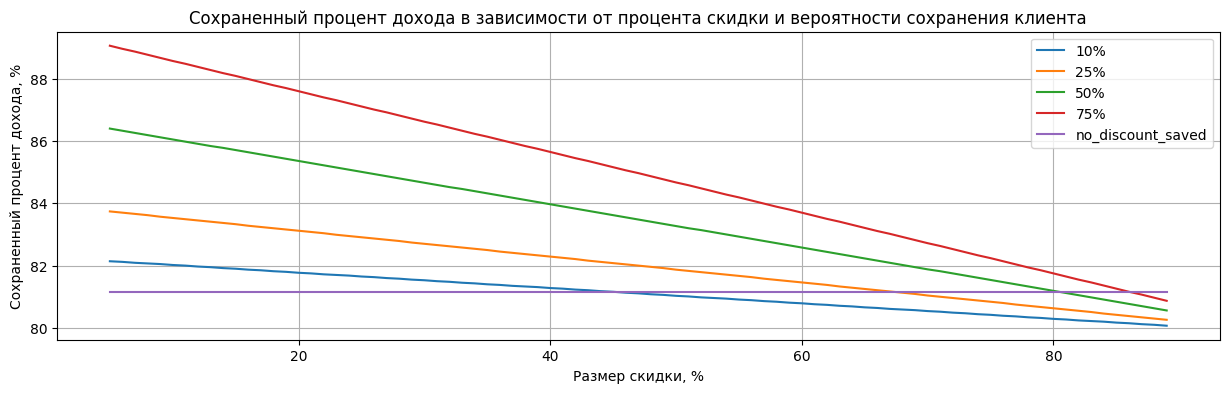

In [72]:
plt.figure(figsize=[15, 4])
for i in ['10%', '25%', '50%', '75%', 'no_discount_saved']:
    sns.lineplot(data=saved, x='discount%', y=i, label=i)
plt.title('Сохраненный процент дохода в зависимости от процента скидки и вероятности сохранения клиента')
plt.ylabel('Сохраненный процент дохода, %')
plt.xlabel('Размер скидки, %')
plt.grid()
plt.show()

**Вывод (актуально для имеющихся тестовых данных):**

При увеличении размера скидки процент сохраненного дохода падает. 

- Скидка в 60% увеличивает сохранении доходов лишь на 2% даже при условии, что предложение примут 75% клиентов.
- Если останутся лишь 25% клиентов, то при скидке в 60% доход упадет еще ниже.
- Наилучшие показатели сохраненного дохода при вероятности сохранения 50% клиентов имеем при скидке размером в 5-10% - в таком случае удастся увеличить сохраненный доход на 5%.
- При наименьшем проценте согласия остаться на условиях наименьшей скидки в 5%.

Максимальный безопасный размер скидки - 30%.

**Необходимы дальнейшие исследования и более тщательный анализ.** 
_________

*На основании же имеющихся тестовых данных можно заключить следующее: чтобы снизить сокращение доходов, в данном случае рекомендуется:*
- предлагать скидку 20-30% - в таком случае процент сохраненного дохода будет составлять от 0.2% до 6% в зависимости от процента согласия абонентов остаться с провайдером. 



#### Меняем порог классификации

Посмотрим, как изменятся значения при разных порогах классификации: 
- Чем ниже порог, тем больший процент потенциально уходящих клиентов будет выявлять модель, но также будет и иметь больший процент ошибок. 
- С высоким порогом точность классификации клиента как уходящего будет выростать, но процент найденных моделью реально уходящих клиентов будет снижаться.

Для этого дополним таблицу test_joined предсказаниями таргета при пороге классификации от 0.2 до 0.8:

In [73]:
test_joined = test_joined[['monthly_charges', 'ended', 'preds']]

for i in np.arange(0.2, 0.8, 0.1):
    test_joined[f'preds_{i.round(1)}'] = pred_proba
    test_joined[f'preds_{i.round(1)}'] = test_joined[f'preds_{i.round(1)}'].apply(lambda x: 1 if x>=i else 0)

test_joined.head()

,monthly_charges,ended,preds,preds_0.2,preds_0.3,preds_0.4,preds_0.5,preds_0.6,preds_0.7,preds_0.8
customer_id,,,,,,,,,,
8597-CTXVJ,64.95,0,0,0,0,0,0,0,0,0
6210-KBBPI,99.45,0,0,0,0,0,0,0,0,0
8685-WHQPW,74.40,1,1,1,1,1,1,1,0,0
3623-FQBOX,19.95,0,0,0,0,0,0,0,0,0
5313-FPXWG,24.60,1,1,1,1,1,1,1,0,0


... и добавим расчеты в таблицу saved:

In [74]:
for i in np.arange(0.2, 0.8, 0.1):
    name = f'preds_{i.round(1)}'
    definded_loses = test_joined.loc[(test_joined[name]==1) & (test_joined[name]==test_joined['ended']), 'monthly_charges'].sum().round(2)
    uncorrect_1 = test_joined.loc[(test_joined[name]==1)&(test_joined[name]!=test_joined['ended']),'monthly_charges'].sum().round(2)
    
    saved[f'10%_for_{name}'] = (
        (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.1 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

    saved[f'25%_for_{name}'] = (
        (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.25 - uncorrect_1*saved['discount'])/full_sum*100).round(2)

    saved[f'50%_for_{name}'] = (
        (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.5 - uncorrect_1*saved['discount'])/full_sum*100).round(2)
    
    saved[f'75%_for_{name}'] = (
        (full_sum - all_loses + definded_loses*(1-saved['discount'])*0.75 - uncorrect_1*saved['discount'])/full_sum*100).round(2)
    
saved.head()

,discount,discount%,10%,25%,50%,75%,no_discount_saved,10%_for_preds_0.2,25%_for_preds_0.2,50%_for_preds_0.2,...,50%_for_preds_0.6,75%_for_preds_0.6,10%_for_preds_0.7,25%_for_preds_0.7,50%_for_preds_0.7,75%_for_preds_0.7,10%_for_preds_0.8,25%_for_preds_0.8,50%_for_preds_0.8,75%_for_preds_0.8
0,0.05,5.0,82.14,83.74,86.40,89.06,81.15,82.08,84.21,87.76,...,85.88,88.27,81.95,83.17,85.20,87.23,81.83,82.86,84.58,86.30
1,0.06,6.0,82.12,83.70,86.33,88.96,81.15,81.96,84.07,87.58,...,85.82,88.19,81.94,83.14,85.15,87.16,81.82,82.84,84.54,86.24
2,0.07,7.0,82.09,83.66,86.26,88.87,81.15,81.85,83.94,87.41,...,85.77,88.10,81.92,83.12,85.11,87.10,81.81,82.82,84.51,86.19
3,0.08,8.0,82.07,83.62,86.19,88.77,81.15,81.74,83.80,87.24,...,85.71,88.02,81.91,83.09,85.06,87.03,81.81,82.80,84.47,86.13
4,0.09,9.0,82.05,83.57,86.12,88.67,81.15,81.62,83.66,87.06,...,85.65,87.94,81.90,83.07,85.02,86.96,81.80,82.79,84.43,86.08


Строим графики зависимостей и смотрим результат:

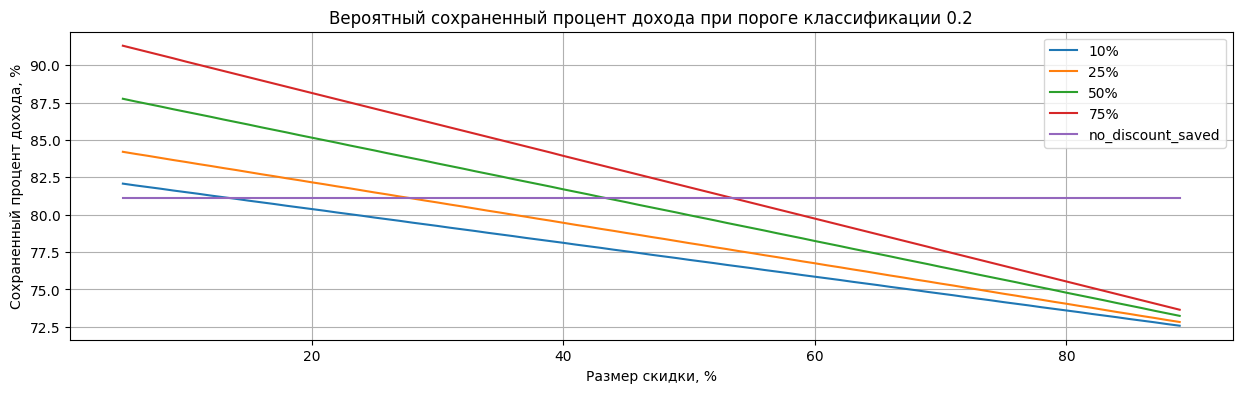

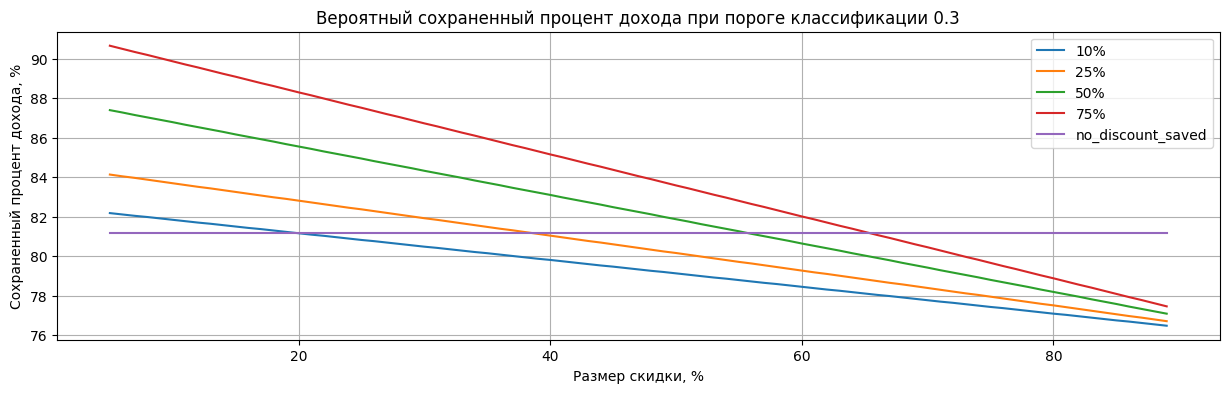

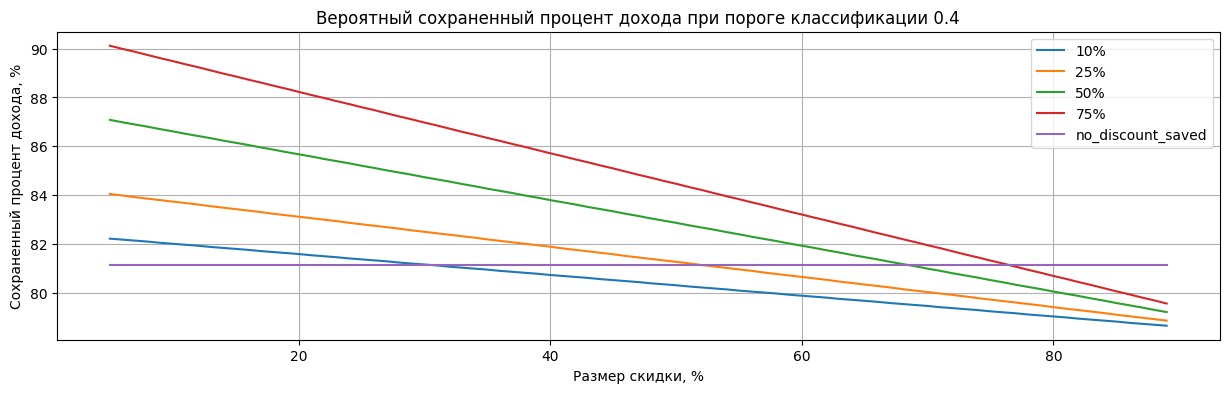

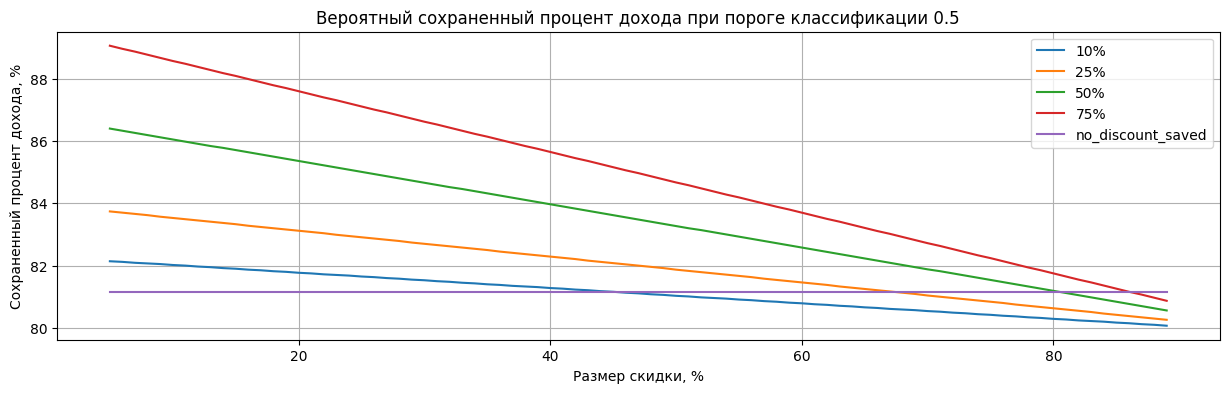

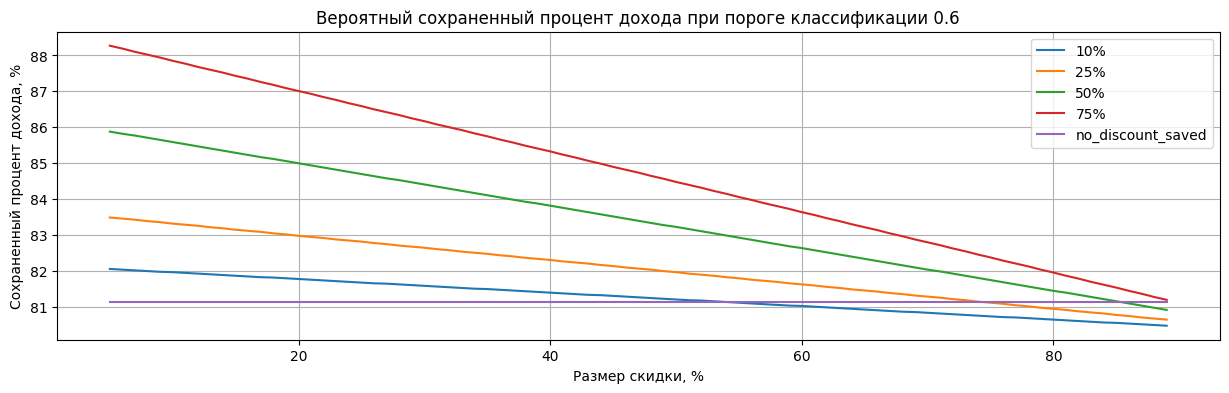

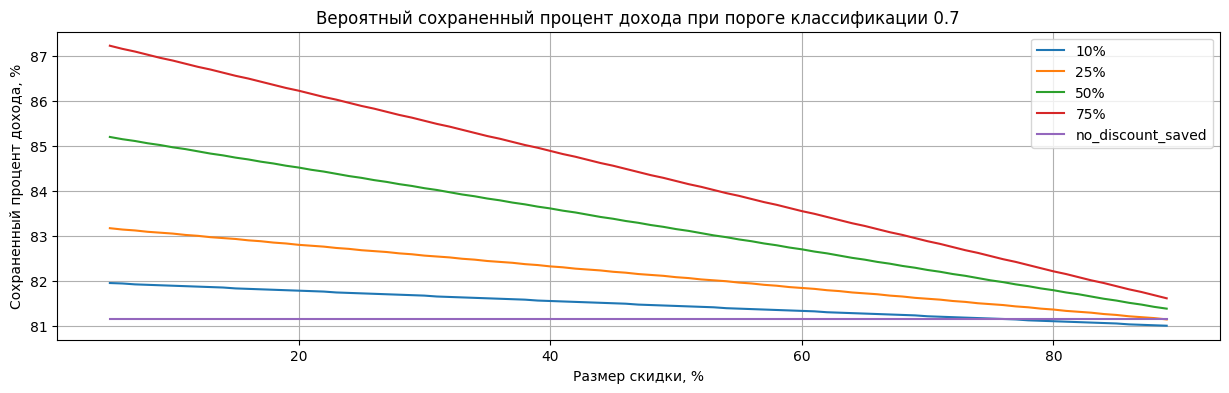

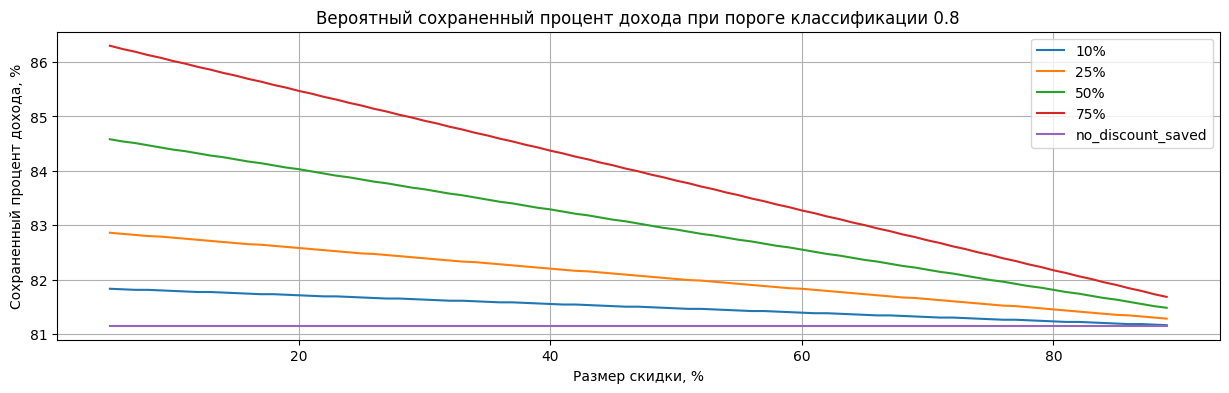

In [75]:
for n in np.arange(0.2, 0.8, 0.1):
    plt.figure(figsize=[15, 4])
    for i in ['10%', '25%', '50%', '75%']:
        sns.lineplot(data=saved, x='discount%', y=f'{i}_for_preds_{round(n, 1)}', label=i)
    sns.lineplot(data=saved, x='discount%', y=f'no_discount_saved', label='no_discount_saved')
    plt.title(f'Вероятный сохраненный процент дохода при пороге классификации {n.round(1)}')
    plt.ylabel('Сохраненный процент дохода, %')
    plt.xlabel('Размер скидки, %')
    plt.grid()
    plt.show()

__________

**Вывод:**

Видим, что при увеличении порога классификации имеем уменьшение максимально возможного сохраненного процента дохода.

Но при этом, что очень важно, растет уровень максимально возможной скидки, при которой удастся минимально сохранить доход. На графиках видим, что угол наклона прямых уменьшается с возрастанием порога классификации. Чем больше порог, тем большую скидку с меньшим риском можно предлагать клиенту, и тем выше вероятность, что он согласится (и процент согласившихся будет выше). 

При этом следует соблюдать баланс между максимально возможным сохраненным доходом и минимальным риском уйти в еще большие убытки (ниже черты сохраненного дохода 81.15%)

**Рекомендация:**

- Наиболее оптимальным вариантом является установление порога классификации 0.6 и установление скидки в размере 30-40%.

В таком случае будет достаточно высокая вероятность сохранения клиента с максимально возможным увеличением уровня сохранения дохода в 4% при минимальных рисках его снижения ниже 81.15%.

<a id="11"></a> 
## Общий вывод

**Результат:**

- Успешно обучена модель, определяющая разорвет ли клиент договор с оператором связи.  

Модель:
- LGBMClassifier(learning_rate=0.5440059873416397, max_depth=4, metric='binary_error', n_estimators=82, n_jobs=-1,random_state=100225, verbosity=-1)

ROC-AUC на тестовой выборке:
- 0.92

Такой результат был достигнут благодаря тому, что модель работает на алгоритме градиентного бустинга, с каждой итерацией уменьшая функцию ошибки. Перебор Optun'ой помог подобрать лучшие значения гиперпараметров, в т.ч. количество итераций и шаг learning rate.

___________

**Выводы для бизнеса:**

Точность модели: 91.7%

Модель выявляет 57% клиентов, планирующих разорвать договор. Из клиентов, помеченных моделью как потенциально разрывающих договор, 85% действительно такими являются.

В рамках тестовых данных сумма месячных выплат ушедших клиентов составляла около 18.85% общей суммы доходов, получаемых от всех клиентов за месяц. Предложение скидок клиентам, которых модель определяет как готовых разорвать договор, позволит снизить эти убытки ориентировочно до 18.5% - 13%, в зависимости от размера скидок и процента клиентов, согласившихся остатся на таких условиях.

На текущем этапе рекомендуется установить скидку 20-30%.

*Необходимы дальнейшие исследования для определения более точного размера предлагаемой клиентам скидки.*


**Рекомендации бизнесу:**

В процессе работы выявлено следующее:

Наибольший риск ухода клиента - при длительности договора от 15 до 55 месяцев. После - риск ухода значительно снижается.

Больший процент ухода обнаружен среди клиентов с большим количеством подключенных сервисов и большой месячной оплатой.

Среди клиентов с помесячной оплатой значительно реже встречаются те, кто разорвал договор. Среди клиентов, платящих раз в 1-2 года процент таких клиентов выше.

Среди ушедших клиентов выше доля типа подключения DSL, чем среди действующих, чаще подключена опция блокировки опасных сайтов.

Также подключенная тех поддержка чаще встречается у ушедших клиентов.


1. Признаки, понижающие риск ухода абонента:
    - Долгое пользование услугами
    - Низкая стоимость за месяц
    - Помесячная оплата
    - Методы оплаты - Чек по почте и электронный чек

2. Повышенный риск ухода абонента:
    - Высокие расходы за услуги за месяц
    - Оплата раз в год / раз в два года
    - Наличие супруги/супруга
    - Пенсионеры
    - Большое количество подключенных сервисов

________

**Ход работы:**


**1 Загрузка данных:**

4 датасета: contract, personal, internet, phone.  
Содержат разную информацию, имеют разную структуру, размерность и типы данных. 

- contract - 7043 строк, 8 столбцов
- personal - 7043 строк, 5 столбцов
- internet - 5517 строк, 8 столбцов
- phone - 6361 строк, 2 столбца

**2 Предобработка и анализ данных:**
- Названия столбцов всех датасетов приведены к виду under_score: Большие буквы заменены на маленькие, слова разделены нижним подчеркиванием.
- В `total_charges` датасета contracts заменили пустые значения на значение месячного платежа, привели столбец к типу float.
- Пропусков и дубликатов (явных) в датасете не выявлено.
- Айди каждого клиентов в каждом из датасетов представлен не более одного раза.

Какую информацию содержат датасеты:

- `type` - три вида оплаты: помесячная, за год, за два года,
- `paperless_billing` - получают ли эл-ный платежный лист: да/нет,
- `payment_method` - 4 вида типа платежа
- `begin_date` - заключенные договоры с 2013 по 2020 годы,
- `end_date` - расторгнутые договоры с 2014 по 2020 год + значение 'No' (даты окончания действия договора нет)
- `monthly_charges` - расходы за месяц -  от 18,25 до 118,75 у.е. в месяц
- `total_charges` - общие расходы абонента - от 19.05 до 9221.38
- Пол - 2 значения (муж, жен)
- Супруг/супруга - 2 значения (да, нет)
- Пенсионер - 0/1 (да, нет)
- Тип подключения - 'DSL' или 'Fiber optic'
- Признаки, содержащие только значения Да/Нет:
  - Блокировка опасных сайтов, облачное хранилище, тех поддержка, антивирус, стриминговое ТВ, каталог фильмов
- есть ли функция подключения телефона к нескольким линиям одновременно:
  - да/нет


**3 Объединение датасетов:**

Датасеты объединены.

В следствие объединения были обнаружены пропуски - все заполнены значением 'unknown', поскольку на основании других признаков нужные категории с уверенностью установить нельзя.


**4 Создание и отбор признаков:**

Созданы следующие признаки:
- целевой признак `ended` (1/0 - ушел ли клиент)
- время действия договора `duration`
- количество подключенных сервисов `services_nums`

Удалены:
- `TotalCharges`, `BeginDate` и `EndDate`, `personal`, `total_charges`.



**5 Исследовательских анализ данных:**

В результате исследовательского анализа данных с разбивкой по целевому признаку пришли к следующим выводам:

У ушедших клиентов, в сравнении с действующими:
- Время договора: Медианное и среднее выше, межквартильный размах значительно меньше, наибольший риск ухода абонента -  от 18.9 до 41 месяца, после 50 месяцев пользования процент ушедших клиентов спадает
- Расходы за месяц: более высокие расходы за месяц, среднее и медианное - 75.5 и 84.2, разброс примерно одинаковый, межквартильный размах снова чуть меньше.
- Помесячная оплата встречается значительно реже. (Заметно чаще расторгали договор клиенты с оплатой раз в 1/2 года.)
- Ниже доля оплаты кредитной картой на 10%. Доля Bank Transfer - выше на 8%.

Среди ушедших клиентов:
- Выше на 6% доля пенсионеров
- Реже на 10% есть супруг/супруга
- Незначительно чаще есть дети.

Также среди ушедших клиентов:
- выше доля типа подключения DSL
- чаще подключена опция блокировки опасных сайтов.
- Чаще была подключена техническая поддержка.

Также заметно, что клиенты с подключенным стриминговым телевидением и каталогом фильмов уходят реже.


**6 Корреляционный анализ данных:**

Матрица корреляции указала на наличие большого количества признаков с мультиколлинеарностью. 

Для устранения проблемы были удалены следующие признаки:
- 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'

**7 Подготовка данных:** 

1. Датасет разбит на тренировочную и тестовую выборки в соотношении 3 к 1, соблюден баланс классов
2. Определены списки категориальных и числовых величин
3. Построен и применен к датасетам пайплайн для кодирования и масштабирования признаков


**8 Обучение моделей:**

Модели успешно обучены. Лучшие:
- LogisticRegression(C=87.32223052945378, random_state=100225)
- SVC(C=0.17731446909323245, kernel='poly', probability=True, random_state=100225)
- KNeighborsClassifier(n_neighbors=75)
- DecisionTreeClassifier(max_depth=49, max_features=11, min_samples_leaf=58, min_samples_split=45, random_state=100225)
- CatboostClassifier('iterations': 446, 'learning_rate': 0.415839266069728, 'l2_leaf_reg': 13, 'depth': 7)
- LGBMClassifier(learning_rate=0.5440059873416397, max_depth=4, metric='binary_error', n_estimators=82, n_jobs=-1,random_state=100225, verbosity=-1)

**9 Анализ результатов лучшей модели:**

Для дальнейшей работы взяли модель LGMClassifier, т.к. она показала лучший результат и чуть более высокую, в сравнении с CatBoost, скорость обучения.

Результаты на тестовой выборке:
- ROC-AUC = 0.92
- Accuracy 91.7%

ROC-кривая:
- Кривая покрывает большую часть площади. В основном модель предсказывает значения целевой переменной правильно.
- Тем не менее, кривая не очень резко меняет наклон. Наивысший TPR при низкой FPR - в районе 0.85.

Другие метрики:
- Precision:  0.85
- Recall:  0.57
- По матрице ошибок видим, что среди ушедших клиентов модель верно классифицировала 157 и упустила 118.

Анализ важности признаков:

- Понижают риск ухода абонента:
    - Долгое пользование услугами
    - Низкая стоимость за месяц
    - Помесячная оплата
    - Методы оплаты - Чек по почте и электронный чек

- Повышенный риск ухода абонента:
    - Высокие расходы за услуги за месяц
    - Оплата раз в год / раз в два года
    - Наличие супруги/супруга
    - Пенсионеры
    - Большое количество подключенных сервисов


**10 Выводы для бизнеса:** 

При увеличении размера скидки процент сохраненного дохода падает. 

- Скидка в 60% увеличивает сохранении доходов лишь на 2% даже при условии, что предложение примут 75% клиентов.
- Если останутся лишь 25% клиентов, то при скидке в 60% доход упадет еще ниже.
- Наилучшие показатели сохраненного дохода при вероятности сохранения 50% клиентов имеем при скидке размером в 5-10% - в таком случае удастся увеличить сохраненный доход на 5%.
- При наименьшем проценте согласия остаться на условиях наименьшей скидки в 5%.

Максимальный безопасный размер скидки - 30%.

*На основании имеющихся тестовых данных можно заключить следующее: чтобы снизить сокращение доходов, в данном случае рекомендуется:*
- предлагать скидку 20-30% - в таком случае процент сохраненного дохода будет составлять от 0.2% до 6% в зависимости от процента согласия абонентов остаться с провайдером. 
